# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Install Pacakges</div>

In [1]:
!pip install datasets lxml TinyImageNet matplotlib seaborn torch torchvision scipy scikit-learn safe_pfl_utils tabulate --quiet

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Import Libraries</div>

In [2]:
import sys
import copy
import csv
import gc
import logging
import logging.config
import os
import os.path
import random
import tarfile
import warnings
from datetime import datetime
from functools import partial
from math import sqrt
from typing import Callable, Optional
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from tinyimagenet import TinyImageNet
from torch import nn
from torch.autograd import Variable
from torch.utils.model_zoo import tqdm
from torchvision.datasets import (
    CIFAR10,
    CIFAR100,
    MNIST,
    STL10,
    SVHN,
    DatasetFolder,
    FashionMNIST,
    ImageFolder,
)
from torchvision.datasets.utils import check_integrity, download_file_from_google_drive
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import Normalize
from safe_pfl_utils.config import Config
from safe_pfl_utils.constants import (
    data_distribution_constants,
    datasets_constants,
    models_constants,
    distances_constants,
)
from tabulate import tabulate

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Configs</div>

In [3]:
DESIRED_DISTRIBUTION = [
    [2948, 0, 5293, 0, 0, 0, 0, 0, 0, 0],
    [1000, 0, 2330, 0, 0, 0, 0, 0, 0, 0],
    [1000, 0, 5292, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4249, 3729, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 3729, 0, 2465, 0, 0, 0],
    [0, 0, 0, 3720, 0, 0, 2145, 0, 0, 0],
    [0, 0, 0, 0, 0, 3865, 2864, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1865, 2863, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5045, 3248],
    [0, 0, 0, 0, 0, 0, 0, 3465, 0, 1329],
]

configurations = Config(
    MODEL_TYPE=models_constants.MODEL_CNN,
    DATASET_TYPE=datasets_constants.DATA_SET_FMNIST,
    DATA_DISTRIBUTION_KIND=data_distribution_constants.DATA_DISTRIBUTION_FIX,
    DISTANCE_METRIC=distances_constants.DISTANCE_COSINE,
    DESIRED_DISTRIBUTION=DESIRED_DISTRIBUTION,
    CLUSTERING_PERIOD=8,
    FEDERATED_LEARNING_ROUNDS=80,
    SAVE_BEFORE_AGGREGATION_MODELS=False,
    SENSITIVITY_PERCENTAGE=10,
    NUMBER_OF_EPOCHS=1
)

SAFE_PFL_CONFIG = configurations.get_config()

SAFE_PFL_CONFIG.update({
    "SAVE_ORDERED_PARAMETERS": False
})

#! “fedbn”: Keeps BN parameters local (FedBN-style)
#! “fedavg”: Standard FedAvg for BN params
#! “partial”: Special handling for ResNet/MobileNet
SAFE_PFL_CONFIG.update({
    "BN_STRATEGY": "fedavg",  # or "fedavg"/"partial"
    "USE_DATA_WEIGHTING": False,  #!
})

SAFE_PFL_CONFIG.update({
    "EXTREME_NONIID": True,
})

SAFE_PFL_CONFIG.update({
    "BN_GRADIENT_SCALE": 1,
    # Reduce BN parameter influence (0.3)        #!  Li et al. (2021) + Chen et al. (2022)	BN parameter decoupling in FL
    "NON_BN_BOOST": 1,
    # Increase non-BN layer importance  (1.2)    #!  Yang et al. (2023)	Gradient stability in heterogeneous FL
    "CONV_KERNEL_BOOST": 1,
    # Emphasize spatial features (1.5)           #!  CONV_KERNEL_BOOST	He et al. (2023)	Spatial feature preservation
    "CLASSIFIER_BOOST": 1,
    # Reduce overfitting to final layer (0.8)         #!  Oh et al. (2022)	Class-imbalance adaptation
    "BN_STABILITY_BATCHES": 1
    # Number of batches for gradient averaging (3)   #!  Zhang et al. (2023)	Model-aware FL optimization
})

# if SAFE_PFL_CONFIG["EXTREME_NONIID"]:
#     SAFE_PFL_CONFIG.update({
#         "BN_GRADIENT_SCALE": 0.2 if "resnet" in SAFE_PFL_CONFIG["MODEL_TYPE"] else 0.35,
#         "CLASSIFIER_BOOST": 0.7 if SAFE_PFL_CONFIG["DATASET_TYPE"] == "non_iid" else 1.0
#     })

# For mobile networks:
# if SAFE_PFL_CONFIG["MODEL_TYPE"] == "mobilenet":
#     SAFE_PFL_CONFIG["CONV_KERNEL_BOOST"] = 1.8  # Depthwise conv importance



In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ["PL_GLOBAL_SEED"] = str(seed)

sns.set_theme(
    style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus": False}
)
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to produce reproducible results (like random.seed())
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False

In [5]:
class Log:
    def __init__(self):
        log_path = datetime.now().strftime(
            f'Model={SAFE_PFL_CONFIG["MODEL_TYPE"]}-Dataset={SAFE_PFL_CONFIG["DATASET_TYPE"]}-N={SAFE_PFL_CONFIG["PARTITION"]}-P={SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"]}_on={SAFE_PFL_CONFIG["DISTANCE_METRIC"]}_at=%Y-%m-%d_%H')
        log_file = "logs/" + log_path + ".log"

        os.makedirs("logs", exist_ok=True)

        if os.path.exists(log_file):
            try:
                os.remove(log_file)
                print(f"Old log file '{log_file}' deleted.")
            except PermissionError as _:
                print("Log file deletion can cause data lost, if you are sure please restart you session")
                
        self.log_instance = logging.getLogger("SAFE_PFL_LOGGER")
        self.log_instance.setLevel(logging.DEBUG)
        self.log_instance.propagate = False

        formatter = logging.Formatter(
            fmt='%(asctime)s, line: %(lineno)d %(levelname)8s | %(message)s',
            datefmt='%Y/%m/%d %H:%M:%S'
        )

        # Create a file handler
        file_handler = logging.FileHandler(log_file, mode='a')
        file_handler.setFormatter(formatter)
        self.log_instance.addHandler(file_handler)

        # Create a stream handler (for console output)
        screen_handler = logging.StreamHandler(stream=sys.stdout)
        screen_handler.setFormatter(formatter)
        self.log_instance.addHandler(screen_handler)

        self.log_instance.info("Logger object created successfully...")
        self.log_instance.warning(f"The {log_file} will be truncated at each run")

    def info(self, info: str):
        self.log_instance.info(info)
        self.flush()

    def warn(self, warn: str):
        self.log_instance.warning(warn)
        self.flush()

    def debug(self, debug: str):
        self.log_instance.debug(debug)
        self.flush()

    def critical(self, critical: str):
        self.log_instance.critical(critical)
        self.flush()

    def error(self, error: str):
        self.log_instance.error(error)
        self.flush()

    def flush(self):
        for handler in self.log_instance.handlers:
            if hasattr(handler, 'flush'):
                handler.flush()

    def close(self):
        self.log_instance.handlers.close()

In [6]:
log = Log()

Old log file 'logs/Model=cnn-Dataset=fmnist-N=noniid-fix-P=10_on=cosine_at=2025-02-02_13.log' deleted.
2025/02/02 13:09:57, line: 35     INFO | Logger object created successfully...
2025/02/02 13:09:57, line: 36  WARNING | The logs/Model=cnn-Dataset=fmnist-N=noniid-fix-P=10_on=cosine_at=2025-02-02_13.log will be truncated at each run


In [7]:
table_data = [[key, value] for key, value in SAFE_PFL_CONFIG.items()]
log.info(tabulate(table_data, headers=["Config Key", "Value"], tablefmt="grid"))

2025/02/02 13:09:57, line: 39     INFO | +--------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Config Key                     | Value                                                                                                                                                                                                                                                                                                                                                                                        |
+================================+=========================================================================================

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Garbage Collection</div>

In [8]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def print_gpu_memory():
    log.info(f"Allocated memory: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
    log.info(f"Cached memory: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")


log.info("before memory cleaning")
print_gpu_memory()

gc.collect()
torch.cuda.empty_cache()

# cuda.select_device(0)
# cuda.close()

log.info("after memory cleaning")
print_gpu_memory()

# ----------- manually clear memory in case of any error
#!sudo fuser -v /dev/nvidia* or nvidia-smi
# remove all python process ids from gpu
#!sudo kill -9 PID.

#* Make directories
!mkdir "models"
!mkdir "models/before_aggregation"

2025/02/02 13:09:57, line: 39     INFO | before memory cleaning
2025/02/02 13:09:57, line: 39     INFO | Allocated memory: 0.00 MB
2025/02/02 13:09:57, line: 39     INFO | Cached memory: 0.00 MB
2025/02/02 13:09:57, line: 39     INFO | after memory cleaning
2025/02/02 13:09:57, line: 39     INFO | Allocated memory: 0.00 MB
2025/02/02 13:09:57, line: 39     INFO | Cached memory: 0.00 MB


A subdirectory or file models already exists.
A subdirectory or file models/before_aggregation already exists.


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Model Network</div>

In [9]:
class Net(nn.Module):
    def __init__(
            self, _model_type: str, _number_of_classes: int
    ):
        super(Net, self).__init__()

        self._model_type = _model_type
        self._number_of_classes = _number_of_classes

        if self._model_type == "resnet18":
            self.resnet = models.resnet18(pretrained=False)
            self.resnet.fc = nn.Linear(
                self.resnet.fc.in_features, self._number_of_classes
            )
        elif self._model_type == "resnet50":
            self.resnet = models.resnet50(pretrained=False)
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self._number_of_classes)

        elif self._model_type == "cnn":
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: 1x28x28, Output: 32x28x28
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32x28x28, Output: 64x28x28
            # Max pooling layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduces spatial dimensions by half
            # Fully connected layers
            self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input: 64x7x7, Output: 128
            self.fc2 = nn.Linear(128, self._number_of_classes)  

        elif self._model_type == "mobilenet":
            self.mobilenet = models.mobilenet_v2(pretrained=False)
            self.mobilenet.classifier[3] = nn.Linear(self.mobilenet.classifier[3].in_features, self._number_of_classes)

        elif self._model_type == "alexnet":
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            self._to_linear = 128 * (128 // 8) * (128 // 8)
            self.classifier = nn.Sequential(
                nn.Linear(self._to_linear, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, self._number_of_classes),
            )

    def forward(self, x):
        out = None

        if self._model_type in ["resnet18", "resnet50"]:
            out = self.resnet(x)
        elif self._model_type == "cnn":
            x = F.relu(self.conv1(x))  # Output: 32x28x28
            x = self.pool(x)  # Output: 32x14x14
            x = F.relu(self.conv2(x))  # Output: 64x14x14
            x = self.pool(x)  # Output: 64x7x7
            # Flatten the output for fully connected layers
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*7*7)
            # Fully connected layers
            x = F.relu(self.fc1(x))  # Output: 128
            x = self.fc2(x)  # Output: num_classes
            return x
        elif self._model_type == "mobilenet":
            out = self.mobilenet(x)

        elif self._model_type == "alexnet":
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            out = x
        return out

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Learning</div>

In [10]:
# def calculate_accuracy(loader, model):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in loader:
#             images, labels = data
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return 100 * correct / total
# 
# 
# def train(net, node_id, train_loader, epochs: int):
#     """Train the network on the training set."""
#     criterion = torch.nn.CrossEntropyLoss()
# 
#     optimizer = torch.optim.Adam(
#         net.parameters(),
#         lr=SAFE_PFL_CONFIG["LEARNING_RATE"],
#         betas=(0.9, 0.999),
#         eps=1e-7,
#         weight_decay=SAFE_PFL_CONFIG["WEIGHT_DECAY"],
#     )
# 
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#     net.train()
#     for epoch in range(epochs):
#         correct, total, epoch_loss = 0, 0, 0.0
# 
#         for images, labels in train_loader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
# 
#             optimizer.zero_grad()
# 
#             outputs = net(images)
#             loss = criterion(outputs, labels)
# 
#             loss.backward()
#             optimizer.step()
# 
#             epoch_loss += loss.item()
#             total += labels.size(0)
#             correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
# 
#         scheduler.step()
# 
#         epoch_loss /= len(train_loader.dataset)
#         epoch_acc = correct / total
# 
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
# 
#     # Return the final accuracy and loss
#     return epoch_acc, epoch_loss
# 
# 
# def test(net, test_loader):
#     """Evaluate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct, total, loss = 0, 0, 0.0
#     net.eval()
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
#             outputs = net(images)
#             loss += criterion(outputs, labels).item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     loss /= len(test_loader.dataset)
#     accuracy = correct / total
#     return accuracy, loss

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Client</div>

In [11]:
# class Client:
#     def __init__(self, net, node_id, train_loader, test_loader):
#         self.net = net.to(DEVICE)
#         self.train_loader = train_loader
#         self.test_loader = test_loader
#         self.node_id = node_id
#         self.train_acc, self.test_acc = 0.0, 0.0
#         self.global_net = Net(SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]).to(DEVICE)
# 
#     def set_shard(self, shard):
#         self.shard = shard
# 
#     def get_global_net(self):
#         return self.global_net
# 
#     def setting_parameters(self, parameters: List[np.ndarray]):
#         params_dict = zip(self.net.state_dict().items(), parameters)
#         state_dict = OrderedDict(
#             {k: torch.Tensor(v).to(DEVICE) for k, v in params_dict}
#         )
#         self.net.load_state_dict(state_dict, strict=True)
# 
#     def getting_parameters(self) -> List[np.ndarray]:
#         return [val.cpu().numpy() for _, val in self.net.state_dict().items()]
# 
#     def fit(self, parameters):
#         self.setting_parameters(parameters)
#         train(self.net, self.node_id, self.train_loader, epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"])
#         return self.getting_parameters(), len(self.train_loader), {}
# 
#     def evaluate(self, parameters):
#         self.setting_parameters(parameters)
#         loss, accuracy = test(self.net, self.test_loader)
#         return float(loss), len(self.test_loader), {"accuracy": float(accuracy)}
# 
#     def Train_test_and_return_acc(self):
#         self.train_acc, _ = train(self.net, self.node_id, self.train_loader, SAFE_PFL_CONFIG["ROUND_EPOCHS"])
#         self.test_acc, _ = test(self.net, self.test_loader)
#         return self.train_acc, self.test_acc

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Server</div>

In [12]:
def divide_nested_list(nested_list, divisor):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            divide_nested_list(nested_list[i], divisor)
        else:
            nested_list[i] /= divisor
    return nested_list


def zero_nested_list(nested_list):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            zero_nested_list(nested_list[i])
        else:
            nested_list[i] = 0
    return nested_list

In [13]:
# class Server:
#     def __init__(self, save_dir):
#         self.models = []
#         self.save_dir = save_dir
#         os.makedirs(self.save_dir, exist_ok=True)  # Create the directory if it doesn't exist
# 
#     def append_model(self, model: nn.Module):
#         if not isinstance(model, nn.Module):
#             raise TypeError("Only instances of nn.Module can be appended")
#         self.models.append(model)
# 
#     def aggregate(self):
#         if not self.models:
#             raise ValueError("No models added to the server.")
# 
#         print("Model numbers:", len(self.models))
#         device = next(self.models[0].parameters()).device
# 
#         if SAFE_PFL_CONFIG["SAVE_BEFORE_AGGREGATION_MODELS"]:
#             for i, model in enumerate(self.models):
#                 model_state_dict = model.state_dict()
#                 model_save_path = os.path.join(self.save_dir, f'node_{i}.pth')
#                 torch.save(model_state_dict, model_save_path)
#                 print(f"Saved model {i} state dict to {model_save_path}")
#         else:
#             print(
#                 "Skip saving before aggregation models because the value of `SAFE_PFL_CONFIG.SAVE_BEFORE_AGGREGATION_MODELS` is False")
# 
#         for model in self.models:
#             model.to(device)
# 
#         avg_model = Net(SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]).to(device)
# 
#         with torch.no_grad():
#             for param_name, avg_param in avg_model.named_parameters():
#                 temp = torch.zeros_like(avg_param)
#                 for model in self.models:
#                     model_param = dict(model.named_parameters())[param_name]
#                     temp += model_param.data
#                 avg_param.copy_(temp / len(self.models))
#         return avg_model


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Clustering</div>

In [14]:
def find_num_cluster(clusters):
    num_cluster = []
    for item in clusters:
        if item not in num_cluster:
            num_cluster.append(item)
    return len(num_cluster)


class Clustering:
    def __init__(self, clients, trainLoaders, percentage, step):
        self.clients = clients
        self.step = step
        self.num_nodes = len(clients)
        self.percentage = percentage
        self.Mask_Number = 0
        self.maskIds = []
        self.grads = []
        self.params = []
        self.load_and_calculate_sensitivity(trainLoaders)
        self.similarity = self.calculate_similarity()
        self.Clusters = self.make_clusters()

    def assign_save_ids_to_weights(self, model):
        weight_id_map = {}
        weight_id = 0

        for name, parameter in model.named_parameters():
            weight_id_map[name] = {}
            num_weights = parameter.numel()
            for i in range(num_weights):
                weight_id_map[name][i] = weight_id
                weight_id += 1
        filename = "weight_to_id.csv"
        if not os.path.exists(filename):
            with open(filename, "w", newline="") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["Layer", "Weight Index", "Weight ID"])
                for layer_name, indices in weight_id_map.items():
                    for index, weight_id in indices.items():
                        writer.writerow([layer_name, index, weight_id])
        return weight_id_map

    def load_and_calculate_sensitivity(self, trainLoaders):
        """
        Calculate sensitivity for each client and store the results in the object.
        """
        if SAFE_PFL_CONFIG["DISTANCE_METRIC"] == distances_constants.DISTANCE_COORDINATE:
            base_model = load_torch_model_before_agg(0).to(DEVICE)  # type: ignore
            base_model.eval()
            weight_id_map = self.assign_save_ids_to_weights(base_model)
        else:
            log.info(
                f'skip loading the base model and calculating the `weight_id_map` since the distance metic set to: {SAFE_PFL_CONFIG["DISTANCE_METRIC"]}')

        for cid in self.clients:
            model = load_torch_model_before_agg(cid).to(DEVICE)  # type: ignore
            model.eval()
            if SAFE_PFL_CONFIG["DISTANCE_METRIC"] != distances_constants.DISTANCE_COORDINATE:
                sensitivity_value, params = self.calculate_sensitivity(model, trainLoaders[int(cid)])
                print(f"Model parameters extracted for client #{cid}.")
                self.params.append(params)
            else:
                sensitivity_value, params = self.calculate_sensitivity(model, trainLoaders[int(cid)])
                mask_ID, weights = self.get_maskIds(sensitivity_value, weight_id_map, self.percentage, cid)
                print(f"Model weights and sensitivity data for client #{cid} processed.")
                self.maskIds.append(mask_ID)
                self.grads.append(weights)

    def calculate_sensitivity(self, model, dataloader):
        model.eval()
        criterion = nn.CrossEntropyLoss()

        if SAFE_PFL_CONFIG["DISTANCE_METRIC"] != distances_constants.DISTANCE_COORDINATE:
            log.info(
                f'skip the gradient analysis since the selected distance metic is {SAFE_PFL_CONFIG["DISTANCE_METRIC"]}')
            return {}, torch.cat([param.view(-1) for param in model.parameters()])

        sensitivities = {}
        inputs, labels = next(iter(dataloader))
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        inputs.requires_grad = True
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        for name, parameter in model.named_parameters():
            if "bias" not in name and parameter.requires_grad and parameter.grad is not None:
                grads = parameter.grad.abs().view(-1).cpu().numpy()
                for i, grad in enumerate(grads):
                    sensitivities[(name, i)] = grad

        return sensitivities, {}

    def get_maskIds(
            self, sensitivity_values_node, weight_id_map, sensitive_percentage, cid
    ):
        """
        Get the top sensitive weights and their IDs, and save all model parameters in order of importance before applying top_k.
        """
        num_weights = len(sensitivity_values_node)
        top_k = int(np.ceil(sensitive_percentage * num_weights / 100))
        self.Mask_Number = top_k

        sorted_weights = sorted(
            sensitivity_values_node.items(), key=lambda item: item[1], reverse=True
        )

        if SAFE_PFL_CONFIG["SAVE_ORDERED_PARAMETERS"]:
            self.save_model_parameters(sorted_weights, weight_id_map, cid)

        top_sensitive_weights = sorted_weights[:top_k]

        weights = [weight for (layer, index), weight in sensitivity_values_node.items()]
        top_weight_ids = [
            weight_id_map[layer][index] for (layer, index), _ in top_sensitive_weights
        ]

        return top_weight_ids, weights

    def save_model_parameters(self, sorted_weights, weight_id_map, cid):
        """
        Save all model parameters in order of importance to a file.
        """
        results_dir = f"model_parameters/{self.step}/"
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        parameters_data = []
        for (layer, index), weight in sorted_weights:
            weight_id = weight_id_map[layer][index]
            parameters_data.append({"weight_id": weight_id, "weight_value": weight})

        filename = os.path.join(
            results_dir,
            f"all_model_parameters_ordered_by_importance_for_client_{cid}.csv",
        )
        with open(filename, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=["weight_id", "weight_value"])
            writer.writeheader()
            writer.writerows(parameters_data)

        print(f"All model parameters saved to {filename}")

    def normalize(self, distances, sensitive):
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i + 1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = distances[i][j] / len(
                    sensitive
                )
        return normal_distances

    def calculate_common_ids(self, index1, index2):
        arr1 = self.maskIds[index1]
        arr2 = self.maskIds[index2]
        sarr1 = set(arr1)
        sarr2 = set(arr2)
        inter = sarr1.intersection(sarr2)
        distance1 = len(inter)
        return distance1

    def calculate_similarity(self):
        similarity_matrix = np.zeros((self.num_nodes, self.num_nodes))
        if SAFE_PFL_CONFIG["DISTANCE_METRIC"] == "coordinate":
            for i in range(self.num_nodes):
                similarity_matrix[i, i] = 0
                for j in range(i + 1, self.num_nodes):
                    similarity = self.calculate_common_ids(i, j)
                    similarity_matrix[i, j] = similarity_matrix[j, i] = similarity
        elif SAFE_PFL_CONFIG["DISTANCE_METRIC"] == "cosine":
            for i in range(self.num_nodes):
                similarity_matrix[i, i] = 0
                for j in range(i + 1, self.num_nodes):
                    similarity_matrix[i, j] = similarity_matrix[j, i] = (
                        F.cosine_similarity(self.params[i], self.params[j], dim=0)
                    )
        elif SAFE_PFL_CONFIG["DISTANCE_METRIC"] == "euclidean":
            for i in range(self.num_nodes):
                similarity_matrix[i, i] = 0
                for j in range(i + 1, self.num_nodes):
                    similarity_matrix[i, j] = similarity_matrix[j, i] = -euclidean(
                        self.params[i], self.params[j]
                    )
        elif SAFE_PFL_CONFIG["DISTANCE_METRIC"] == "wasserstein":
            for i in range(self.num_nodes):
                similarity_matrix[i, i] = 0
                for j in range(i + 1, self.num_nodes):
                    similarity_matrix[i, j] = similarity_matrix[j, i] = (
                        -wasserstein_distance(self.params[i], self.params[j])
                    )
        else:
            raise ValueError("Unsupported metric")

        self.save_similarity_to_csv(similarity_matrix)

        log.info.write("similarity Matrix")
        log.info.write(f"{similarity_matrix}")

        return similarity_matrix

    def index_to_value(self, groups):
        value_groups = []
        for group in groups:
            list1 = []
            for index in group:
                list1.append(self.clients[index])
            value_groups.append(list1)
        return value_groups

    def make_clusters(self):
        ap = AffinityPropagation(affinity="precomputed", random_state=42).fit(
            self.similarity
        )
        print(f"cluster results:{ap.labels_}")

        cluster_list = [[] for _ in range(len(np.unique(ap.labels_)))]
        for point_index, cluster_label in enumerate(ap.labels_):
            cluster_list[cluster_label].append(point_index)

        return cluster_list

    def save_similarity_to_csv(self, similarity):
        """
        Save the distance matrix to a CSV file.
        """
        filename = f'similarity_{SAFE_PFL_CONFIG["DISTANCE_METRIC"]}.csv'
        with open(filename, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Node"] + [f"Node_{i}" for i in range(self.num_nodes)])
            for i, row in enumerate(similarity):
                writer.writerow([f"Node_{i}"] + row.tolist())

        print(f"Similarity matrix saved to {filename}")

    def set_top_percent_to_one(self, arr):
        modified_array = np.copy(arr)
        num_elements_to_set = int(len(arr) * self.percentage / 100)
        if num_elements_to_set == 0:
            return modified_array
        indices_to_set = np.argpartition(modified_array, -num_elements_to_set)[
                         -num_elements_to_set:
                         ]
        modified_array[indices_to_set] = 1
        return modified_array

    def set_least_significant_to_zero(self, arr):
        modified_array = np.copy(arr)
        num_elements_to_zero = int(len(arr) * (100 - self.percentage) / 100)
        if num_elements_to_zero == 0:
            return modified_array
        indices_to_zero = np.argpartition(modified_array, num_elements_to_zero)[
                          :num_elements_to_zero
                          ]
        modified_array[indices_to_zero] = 0
        return modified_array

    def get_significant_weights_indices(self, arr):
        num_elements = len(arr)
        num_significant = int(np.ceil(num_elements * self.percentage / 100))
        if num_significant == 0:
            return np.array([], dtype=int)
        significant_indices = np.argpartition(-arr, num_significant - 1)[
                              :num_significant
                              ]
        significant_indices = significant_indices[np.argsort(-arr[significant_indices])]
        return significant_indices

    def zero_insignificant_in_both(self, arr_i, arr_j):
        num_params = len(arr_i)
        significant_indices_i = self.get_significant_weights_indices(arr_i)
        significant_indices_j = self.get_significant_weights_indices(arr_j)
        all_indices = set(range(num_params))
        insignificant_in_i = all_indices - set(significant_indices_i)
        insignificant_in_j = all_indices - set(significant_indices_j)
        insignificant_in_both = insignificant_in_i.intersection(insignificant_in_j)
        modified_arr_i = np.copy(arr_i)
        modified_arr_j = np.copy(arr_j)
        insignificant_in_both = np.array(list(insignificant_in_both), dtype=int)
        modified_arr_i[insignificant_in_both] = 0
        modified_arr_j[insignificant_in_both] = 0
        return modified_arr_i, modified_arr_j

    def get_bn_layer_identifiers(self):
        """Return BN layer identifier patterns for different architectures"""
        return {
            "resnet18": ["bn1", "bn2", "downsample.1"],
            "resnet50": ["bn1", "bn2", "bn3", "downsample.1"],
            "mobilenet": ["bn", "norm"],
            "alexnet": ["features.1", "features.4", "features.7", "classifier.1"],
            "cnn": ["bn"]
        }.get(SAFE_PFL_CONFIG["MODEL_TYPE"], ["bn"])

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Federated Learning</div>

In [15]:
# class FL:
#     def __init__(
#             self,
#             clients,
#             client_initial_models,
#             round_number,
#             train_loaders,
#             test_loaders,
#             SENSITIVITY_PERCENTAGE,
#     ):
#         self.clients = clients
#         self.NUMBER_OF_CLIENTS = len(clients)
#         self.client_initial_models = client_initial_models
#         self.SENSITIVITY_PERCENTAGE = SENSITIVITY_PERCENTAGE
#         self.train_loaders = train_loaders
#         self.test_loaders = test_loaders
#         self.round_number = round_number
#         self.global_model = None
#         self.clustering_result = None
#         self.client_obj_list = []
#         self.accuracies = {}
#         self.training()
# 
#     def training(self):
#         for cid in self.clients:
#             print("cid is:", cid)
#             client = Client(
#                 self.client_initial_models[self.clients.index(int(cid))],
#                 cid,
#                 self.train_loaders[int(cid)],
#                 self.test_loaders[int(cid)],
#             )
#             self.client_obj_list.append(client)
#         global_model = Net(SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"])
#         os.makedirs("models", exist_ok=True)
#         start_time = datetime.now()
#         for r in range(self.round_number):
#             print(f'\nRound {r + 1}/{self.round_number}')
#             server = Server(
#                 f'./models/{SAFE_PFL_CONFIG["MODEL_TYPE"]}/{SAFE_PFL_CONFIG["DATASET_TYPE"]}/{SAFE_PFL_CONFIG["ROUND_EPOCHS"] * SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"] * SAFE_PFL_CONFIG["CLUSTERING_PERIOD"]}_epochs_{SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"] * SAFE_PFL_CONFIG["CLUSTERING_PERIOD"]}_fl_rounds/{(r + 1) * SAFE_PFL_CONFIG["ROUND_EPOCHS"]}_epochs')
#             global_accuracy = 0
#             for cid in self.clients:
#                 train_acc, test_acc = self.client_obj_list[
#                     self.clients.index(cid)
#                 ].Train_test_and_return_acc()
#                 print(
#                     "_____________________________________________________________________________________________________________"
#                 )
#                 print(f"node {cid}: train_acc: {train_acc}, test_acc:{test_acc}")
#                 with open(log_file, "a") as f:
#                     f.write(
#                         f"\nNode {cid} - Round {r + 1}: Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%"
#                     )
#                 global_accuracy += test_acc
#                 server.append_model(self.client_obj_list[self.clients.index(cid)].net)
#             global_model = server.aggregate()
#             end_time = datetime.now()
#             execution_time = end_time - start_time
#             print("time", execution_time)
#             with open(log_file, "a") as f:
#                 f.write(f"\n Exe FL Round Time: {execution_time}")
#             print("global acc:", global_accuracy / self.NUMBER_OF_CLIENTS)
#             with open(log_file, "a") as f:
#                 f.write(
#                     f"\nGlobal Model of {self.NUMBER_OF_CLIENTS}- Round {r + 1}: Test Accuracy is: {global_accuracy / self.NUMBER_OF_CLIENTS}%")
#             for cid in self.clients:
#                 save_torch_model_before_agg(self.client_obj_list[self.clients.index(cid)].net, cid)
# 
#                 self.client_obj_list[self.clients.index(cid)].net = copy.deepcopy(global_model)
# 
#         self.global_model = global_model

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Loading & Saving</div>

In [16]:
def load_torch_model(node_id):
    model_path = f"models/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def load_torch_model_before_agg(node_id):
    model_path = f"models/before_aggregation/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def save_torch_model_before_agg(model, client_id: str):
    model_path = f"models/before_aggregation/node_{client_id}.pth"
    torch.save(model, model_path)


def save_torch_model(model, node_id):
    model_path = f"models/node_{node_id}.pth"
    torch.save(model, model_path)


def save_model_param(model, node_id, round_number):
    model_path = f"models/node_{node_id}_round_{round_number}.pth"
    torch.save(model.state_dict(), model_path)

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Non-IID Distribution</div>

In [17]:
IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)


def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

class CustomTensorDataset(data.TensorDataset):
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors) + (index,)


class MNIST_truncated(data.Dataset):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = MNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class FashionMNIST_truncated(data.Dataset):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = FashionMNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class SVHN_custom(data.Dataset):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        if self.train is True:

            svhn_dataobj = SVHN(
                self.root, "train", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels
        else:
            svhn_dataobj = SVHN(
                self.root, "test", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]
        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


# torchvision CelebA
class CelebA_custom(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        (
            "0B7EVK8r0v71pZjFTYXZWM3FlRnM",
            "00d2c5bc6d35e252742224ab0c1e8fcb",
            "img_align_celeba.zip",
        ),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        (
            "0B7EVK8r0v71pblRyaVFSWGxPY0U",
            "75e246fa4810816ffd6ee81facbd244c",
            "list_attr_celeba.txt",
        ),
        (
            "1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS",
            "32bd1bd63d3c78cd57e08160ec5ed1e2",
            "identity_CelebA.txt",
        ),
        (
            "0B7EVK8r0v71pbThiMVRxWXZ4dU0",
            "00566efa6fedff7a56946cd1c10f1c16",
            "list_bbox_celeba.txt",
        ),
        (
            "0B7EVK8r0v71pd0FJY3Blby1HUTQ",
            "cc24ecafdb5b50baae59b03474781f8c",
            "list_landmarks_align_celeba.txt",
        ),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        (
            "0B7EVK8r0v71pY0NSMzRuSXJEVkk",
            "d32c9cbf5e040fd4025c592c306e6668",
            "list_eval_partition.txt",
        ),
    ]

    def __init__(
            self,
            root,
            dataidxs=None,
            split="train",
            target_type="attr",
            transform=None,
            target_transform=None,
            download=False,
    ):
        import pandas

        super(CelebA_custom, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.split = split
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError("target_transform is specified but target_type is empty")

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted."
                + " You can use download=True to download it"
            )

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[split.lower()]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(
            fn("list_eval_partition.txt"),
            delim_whitespace=True,
            header=None,
            index_col=0,
        )
        identity = pandas.read_csv(
            fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0
        )
        bbox = pandas.read_csv(
            fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0
        )
        landmarks_align = pandas.read_csv(
            fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1
        )
        attr = pandas.read_csv(
            fn("list_attr_celeba.txt"), delim_whitespace=True, header=1
        )

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)
        self.gender_index = self.attr_names.index("Male")
        self.dataidxs = dataidxs
        if self.dataidxs is None:
            self.target = self.attr[
                          :, self.gender_index: self.gender_index + 1
                          ].reshape(-1)
        else:
            self.target = self.attr[
                          self.dataidxs, self.gender_index: self.gender_index + 1
                          ].reshape(-1)

    def _check_integrity(self):
        for _, md5, filename in self.file_list:
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False

        # Should check a hash of the images
        return os.path.isdir(
            os.path.join(self.root, self.base_folder, "img_align_celeba")
        )

    def download(self):
        import zipfile

        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        for file_id, md5, filename in self.file_list:
            download_file_from_google_drive(
                file_id, os.path.join(self.root, self.base_folder), filename, md5
            )

        with zipfile.ZipFile(
                os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r"
        ) as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        if self.dataidxs is None:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[index],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[index, self.gender_index])
                elif t == "identity":
                    target.append(self.identity[index, 0])
                elif t == "bbox":
                    target.append(self.bbox[index, :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[index, :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))
        else:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[self.dataidxs[index]],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[self.dataidxs[index], self.gender_index])
                elif t == "identity":
                    target.append(self.identity[self.dataidxs[index], 0])
                elif t == "bbox":
                    target.append(self.bbox[self.dataidxs[index], :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[self.dataidxs[index], :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))

        if self.transform is not None:
            X = self.transform(X)
        # print("target[0]:", target[0])
        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None
        # print("celeba target:", target)
        return X, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.attr)
        else:
            return len(self.dataidxs)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)


class STL10_truncated(data.Dataset):
    def __init__(self, root, dataidxs=None, split="train", transform=None, target_transform=None, download=False):
        """
        Custom STL10 dataset with support for data indexing.
        Args:
            root (str): Dataset root directory.
            dataidxs (list, optional): Indices for data partitioning. Defaults to None.
            split (str, optional): Dataset split ('train', 'test', 'unlabeled'). Defaults to 'train'.
            transform (callable, optional): Transformations for the input data. Defaults to None.
            target_transform (callable, optional): Transformations for the target labels. Defaults to None.
            download (bool, optional): Whether to download the dataset. Defaults to False.
        """
        self.root = root
        self.dataidxs = dataidxs
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.download = download
        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        stl10_dataobj = STL10(
            self.root, split=self.split, transform=self.transform, target_transform=self.target_transform,
            download=self.download
        )
        data = stl10_dataobj.data
        target = np.array(stl10_dataobj.labels)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the class index.
        """
        img, target = self.data[index], self.target[index]

        # Ensure the image has the correct shape and dtype for PIL
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = img.astype(np.uint8)  # Ensure dtype is uint8 for PIL compatibility
        img = Image.fromarray(img)  # Convert to PIL Image

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class CIFAR10_truncated(data.Dataset):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = cifar_dataobj.data
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            if isinstance(self.dataidxs, (list, np.ndarray, tuple)):
                self.dataidxs = np.array(self.dataidxs, dtype=np.int64)
                data = data[self.dataidxs]
                target = target[self.dataidxs]
            else:
                raise TypeError("dataidxs must be a list, numpy array, or None.")

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


def gen_bar_updater() -> Callable[[int, int, int], None]:
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update


def download_url(
        url: str, root: str, filename: Optional[str] = None, md5: Optional[str] = None
) -> None:
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    # check if file is already present locally
    if check_integrity(fpath, md5):
        print("Using downloaded and verified file: " + fpath)
    else:  # download the file
        try:
            print("Downloading " + url + " to " + fpath)
            urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
        except (urllib.error.URLError, IOError) as e:  # type: ignore[attr-defined]
            if url[:5] == "https":
                url = url.replace("https:", "http:")
                print(
                    "Failed download. Trying https -> http instead."
                    " Downloading " + url + " to " + fpath
                )
                urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
            else:
                raise e
        # check integrity of downloaded file
        if not check_integrity(fpath, md5):
            raise RuntimeError("File not found or corrupted.")


def _is_tarxz(filename: str) -> bool:
    return filename.endswith(".tar.xz")


def _is_tar(filename: str) -> bool:
    return filename.endswith(".tar")


def _is_targz(filename: str) -> bool:
    return filename.endswith(".tar.gz")


def _is_tgz(filename: str) -> bool:
    return filename.endswith(".tgz")


def _is_gzip(filename: str) -> bool:
    return filename.endswith(".gz") and not filename.endswith(".tar.gz")


def _is_zip(filename: str) -> bool:
    return filename.endswith(".zip")


def extract_archive(
        from_path: str, to_path: Optional[str] = None, remove_finished: bool = False
) -> None:
    if to_path is None:
        to_path = os.path.dirname(from_path)

    if _is_tar(from_path):
        with tarfile.open(from_path, "r") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, "r:gz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, "r:xz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(
            to_path, os.path.splitext(os.path.basename(from_path))[0]
        )
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, "r") as z:
            z.extractall(to_path)
    else:
        raise ValueError("Extraction of {} not supported".format(from_path))

    if remove_finished:
        os.remove(from_path)


def download_and_extract_archive(
        url: str,
        download_root: str,
        extract_root: Optional[str] = None,
        filename: Optional[str] = None,
        md5: Optional[str] = None,
        remove_finished: bool = False,
) -> None:
    download_root = os.path.expanduser(download_root)
    if extract_root is None:
        extract_root = download_root
    if not filename:
        filename = os.path.basename(url)

    download_url(url, download_root, filename, md5)

    archive = os.path.join(download_root, filename)
    print("Extracting {} to {}".format(archive, extract_root))
    extract_archive(archive, extract_root, remove_finished)


class FEMNIST(MNIST):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    resources = [
        (
            "https://raw.githubusercontent.com/tao-shen/FEMNIST_pytorch/master/femnist.tar.gz",
            "59c65cec646fc57fe92d27d83afdf0ed",
        )
    ]

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found." + " You can use download=True to download it"
            )
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        self.data, self.targets, self.users_index = torch.load(
            os.path.join(self.processed_folder, data_file)
        )

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode="F")
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def download(self):
        """Download the FEMNIST data if it doesn't exist in processed_folder already."""
        import shutil

        if self._check_exists():
            return

        mkdirs(self.raw_folder)
        mkdirs(self.processed_folder)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition("/")[2]
            download_and_extract_archive(
                url, download_root=self.raw_folder, filename=filename, md5=md5
            )

        # process and save as torch files
        print("Processing...")
        shutil.move(
            os.path.join(self.raw_folder, self.training_file), self.processed_folder
        )
        shutil.move(
            os.path.join(self.raw_folder, self.test_file), self.processed_folder
        )

    def __len__(self):
        return len(self.data)

    def _check_exists(self) -> bool:
        return all(
            check_integrity(
                os.path.join(
                    self.raw_folder,
                    os.path.splitext(os.path.basename(url))[0]
                    + os.path.splitext(os.path.basename(url))[1],
                )
            )
            for url, _ in self.resources
        )


class Generated(MNIST):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if self.train:
            self.data = np.load("data/generated/X_train.npy")
            self.targets = np.load("data/generated/y_train.npy")
        else:
            self.data = np.load("data/generated/X_test.npy")
            self.targets = np.load("data/generated/y_test.npy")

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class genData(MNIST):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class CIFAR100_truncated(data.Dataset):

    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR100(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        if torchvision.__version__ == "0.2.1":
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(
                    cifar_dataobj.train_labels
                )
            else:
                data, target = cifar_dataobj.test_data, np.array(
                    cifar_dataobj.test_labels
                )
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class ImageFolder_custom(DatasetFolder):
    def __init__(
            self,
            root,
            dataidxs=None,
            train=True,
            transform=None,
            target_transform=None,
            download=None,
    ):
        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        imagefolder_obj = ImageFolder(self.root, self.transform, self.target_transform)
        self.loader = imagefolder_obj.loader
        if self.dataidxs is not None:
            self.samples = np.array(imagefolder_obj.samples)[self.dataidxs]
        else:
            self.samples = np.array(imagefolder_obj.samples)

    def __getitem__(self, index):
        path = self.samples[index][0]
        target = self.samples[index][1]
        target = int(target)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.samples)
        else:
            return len(self.dataidxs)

In [18]:
def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def load_mnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = MNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = MNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_fmnist_data(datadir):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    mnist_train_ds = FashionMNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = FashionMNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_svhn_data(datadir):
    transform = transforms.Compose([
        transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    svhn_train_ds = SVHN_custom(datadir, train=True, download=True, transform=transform)
    svhn_test_ds = SVHN_custom(datadir, train=False, download=True, transform=transform)
    X_train, y_train = svhn_train_ds.data, svhn_train_ds.target
    X_test, y_test = svhn_test_ds.data, svhn_test_ds.target
    # X_train = X_train.data.numpy()
    # y_train = y_train.data.numpy()
    # X_test = X_test.data.numpy()
    # y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_cifar10_data(datadir):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    cifar10_train_ds = CIFAR10_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar10_test_ds = CIFAR10_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    return (X_train, y_train, X_test, y_test)


def load_celeba_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    celeba_train_ds = CelebA_custom(
        datadir, split="train", target_type="attr", download=True, transform=transform
    )
    celeba_test_ds = CelebA_custom(
        datadir, split="test", target_type="attr", download=True, transform=transform
    )
    gender_index = celeba_train_ds.attr_names.index("Male")
    y_train = celeba_train_ds.attr[:, gender_index: gender_index + 1].reshape(-1)
    y_test = celeba_test_ds.attr[:, gender_index: gender_index + 1].reshape(-1)
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (None, y_train, None, y_test)


def load_femnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = FEMNIST(datadir, train=True, transform=transform, download=True)
    mnist_test_ds = FEMNIST(datadir, train=False, transform=transform, download=True)
    X_train, y_train, u_train = (
        mnist_train_ds.data,
        mnist_train_ds.targets,
        mnist_train_ds.users_index,
    )
    X_test, y_test, u_test = (
        mnist_test_ds.data,
        mnist_test_ds.targets,
        mnist_test_ds.users_index,
    )
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    u_train = np.array(u_train)
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    u_test = np.array(u_test)
    return (X_train, y_train, u_train, X_test, y_test, u_test)


def load_cifar100_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    cifar100_train_ds = CIFAR100_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar100_test_ds = CIFAR100_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar100_train_ds.data, cifar100_train_ds.target
    X_test, y_test = cifar100_test_ds.data, cifar100_test_ds.target
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (X_train, y_train, X_test, y_test)


def load_tinyimagenet_data(datadir):
    split = "val"
    TinyImageNet(datadir, split=split)
    transform_train = transforms.Compose([
        transforms.RandomCrop(64, padding=4),  # Random cropping with padding
        transforms.RandomHorizontalFlip(),  # Horizontal flip
        transforms.RandomRotation(15),  # Random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]),  # Normalization
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]),
    ])
    # transform = transforms.Compose([transforms.ToTensor()])
    xray_train_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/train/", transform=transform_train
    )
    xray_test_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/val/", transform=transform_test
    )
    X_train, y_train = np.array([s[0] for s in xray_train_ds.samples]), np.array(
        [int(s[1]) for s in xray_train_ds.samples]
    )
    X_test, y_test = np.array([s[0] for s in xray_test_ds.samples]), np.array(
        [int(s[1]) for s in xray_test_ds.samples]
    )
    return (X_train, y_train, X_test, y_test)


def load_stl10_data(datadir):
    transform_train = transforms.Compose([
        transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_test = transforms.Compose([
        transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    stl10_train_ds = STL10_truncated(datadir, split="train", transform=transform_train, download=True)
    stl10_test_ds = STL10_truncated(datadir, split="test", transform=transform_test, download=True)

    X_train, y_train = stl10_train_ds.data, stl10_train_ds.target
    X_test, y_test = stl10_test_ds.data, stl10_test_ds.target

    return X_train, y_train, X_test, y_test


def record_net_data_stats(y_train, net_dataidx_map, logdir):
    net_cls_counts = {}
    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp
    log.info("Data statistics: %s" % str(net_cls_counts))
    return net_cls_counts

In [19]:
def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.1):
    test_dataidx_map = {}

    # Load dataset
    if dataset == "mnist":
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == "fmnist":
        X_train, y_train, X_test, y_test = load_fmnist_data(datadir)
    elif dataset == "cifar10":
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == "svhn":
        X_train, y_train, X_test, y_test = load_svhn_data(datadir)
    elif dataset == "celeba":
        X_train, y_train, X_test, y_test = load_celeba_data(datadir)
    elif dataset == "femnist":
        X_train, y_train, u_train, X_test, y_test, u_test = load_femnist_data(datadir)
    elif dataset == "cifar100":
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == "tinyimagenet":
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)
    elif dataset == "stl10":
        X_train, y_train, X_test, y_test = load_stl10_data(datadir)
    elif dataset == "generated":
        # Code for generated dataset (omitted for brevity)
        pass
    # Add other datasets if needed

    n_train = y_train.shape[0]

    # Partition the data
    if partition == "homo":
        # Homogeneous data partition
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}

    elif partition == "noniid-labeldir":
        min_size = 0
        min_require_size = 10  # Minimum number required for each party
        if dataset == "cifar100":
            K = 100  # Number of classes
        else:
            k = 10

        N = y_train.shape[0]
        net_dataidx_map = {}
        test_dataidx_map = {}  # Make sure to initialize this

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                proportions = np.array(
                    [
                        p * (len(idx_j) < N / n_parties)
                        for p, idx_j in zip(proportions, idx_batch)
                    ]
                )
                proportions = proportions / proportions.sum()  # Normalize
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [
                    idx_j + idx.tolist()
                    for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))
                ]

            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

            # Initialize test_dataidx_map for current party
            test_dataidx_map[j] = []

            # Gather test indices for current party based on labels in net_dataidx_map[j]
            for k in range(K):
                if k in y_train[net_dataidx_map[j]]:
                    # Access test indices for class k
                    idx_test_k = np.where(y_test == k)[0]
                    np.random.shuffle(idx_test_k)

                    # The number of sample for each party based on training set size
                    n_samples = int(len(net_dataidx_map[j]) * len(idx_test_k) / N)
                    test_dataidx_map[j].extend(idx_test_k[:n_samples])

            test_dataidx_map[j] = np.array(test_dataidx_map[j])

        # Cleanup to avoid empty concatenation error
        for j in range(n_parties):
            if len(test_dataidx_map[j]) == 0:
                test_dataidx_map[j] = np.array(
                    []
                )  # Set to an empty array to avoid errors later

    elif partition == "noniid-fix":
        # Custom fixed distribution logic
        desired_distribution = SAFE_PFL_CONFIG["DESIRED_DISTRIBUTION"]

        # Number of clients and classes
        num_clients = len(desired_distribution)
        num_classes = len(desired_distribution[0])

        assert num_clients == SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]
        assert num_classes == SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]

        ##Initialize the data indices for each client
        net_dataidx_map = {i: [] for i in range(num_clients)}
        # Iterate over each class and assign samples to clients based on the desired distribution
        for class_idx in range(num_classes):
            # Get the indices of all samples belonging to the current class
            class_indices = np.where(y_train == class_idx)[0]

            # Shuffle the indices to ensure randomness
            np.random.shuffle(class_indices)

            # Assign samples to clients based on the desired distribution
            start_idx = 0
            for client_idx in range(num_clients):
                num_samples = desired_distribution[client_idx][class_idx]
                if num_samples > 0:
                    end_idx = start_idx + num_samples
                    net_dataidx_map[client_idx].extend(class_indices[start_idx:end_idx])
                    start_idx = end_idx

        # Initialize test_dataidx_map for each client
        for j in range(num_clients):
            test_dataidx_map[j] = []

            # Gather test indices for current party based on labels in net_dataidx_map[j]
            for k in range(num_classes):
                if k in y_train[net_dataidx_map[j]]:
                    # Access test indices for class k
                    idx_test_k = np.where(y_test == k)[0]
                    np.random.shuffle(idx_test_k)

                    # The number of samples for each party based on training set size
                    n_samples = int(len(net_dataidx_map[j]) * len(idx_test_k) / n_train)
                    test_dataidx_map[j].extend(idx_test_k[:n_samples])

            test_dataidx_map[j] = np.array(test_dataidx_map[j])

        # Cleanup to avoid empty concatenation error
        for j in range(num_clients):
            if len(test_dataidx_map[j]) == 0:
                test_dataidx_map[j] = np.array(
                    []
                )  # Set to an empty array to avoid errors later

    elif partition.startswith("noniid-#label") and partition[13:].isdigit():
        # Existing logic for noniid-#label partitioning
        num = int(partition[13:])
        if dataset in ("celeba", "covtype", "a9a", "rcv1", "SUSY"):
            num = 1
            K = 2
        else:
            if dataset == "cifar100":
                K = 100
            elif dataset == "tinyimagenet":
                K = 200
            else:
                K = 10
        if num == K:
            # IID partition
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                idx_k = np.where(y_train == i)[0]
                np.random.shuffle(idx_k)
                split = np.array_split(idx_k, n_parties)
                for j in range(n_parties):
                    net_dataidx_map[j] = np.append(net_dataidx_map[j], split[j])
        else:
            times = [0 for _ in range(K)]
            contain = []
            for i in range(n_parties):
                current = [i % K]
                times[i % K] += 1
                j = 1
                while j < num:
                    ind = random.randint(0, K - 1)
                    if ind not in current:
                        j += 1
                        current.append(ind)
                        times[ind] += 1
                contain.append(current)
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            test_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                if times[i] > 0:
                    idx_k = np.where(y_train == i)[0]
                    idx_t = np.where(y_test == i)[0]
                    np.random.shuffle(idx_k)
                    np.random.shuffle(idx_t)
                    split = np.array_split(idx_k, times[i])
                    splitt = np.array_split(idx_t, times[i])
                    ids = 0
                    for j in range(n_parties):
                        if i in contain[j]:
                            net_dataidx_map[j] = np.append(
                                net_dataidx_map[j], split[ids]
                            )
                            test_dataidx_map[j] = np.append(
                                test_dataidx_map[j], splitt[ids]
                            )
                            ids += 1
    else:
        raise ValueError(f"Unknown partition method: {partition}")

    # Record the data statistics
    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)

    return (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    )

In [20]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, net_id=None, total=0):
        self.std = std
        self.mean = mean
        self.net_id = net_id
        self.num = int(sqrt(total))
        if self.num * self.num < total:
            self.num = self.num + 1

    def __call__(self, tensor):
        if self.net_id is None:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            tmp = torch.randn(tensor.size())
            filt = torch.zeros(tensor.size())
            size = int(28 / self.num)
            row = int(self.net_id / size)
            col = self.net_id % size
            for i in range(size):
                for j in range(size):
                    filt[:, row * size + i, col * size + j] = 1
            tmp = tmp * filt
            return tensor + tmp * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )


def get_dataloader(
        dataset,
        datadir,
        train_bs,
        test_bs,
        dataidxs=None,
        testidxs=None,
        noise_level=0,
        net_id=None,
        total=0,
):
    if dataset in (
            "mnist",
            "femnist",
            "fmnist",
            "cifar10",
            "svhn",
            "generated",
            "covtype",
            "a9a",
            "rcv1",
            "SUSY",
            "cifar100",
            "tinyimagenet",
            "stl10"
    ):
        if dataset == "mnist":
            dl_obj = MNIST_truncated
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "femnist":
            dl_obj = FEMNIST
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "fmnist":
            dl_obj = FashionMNIST_truncated
            log.warn("removed the AddGaussianNoise!")
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,)),
                ]
            )
        elif dataset == "svhn":
            dl_obj = SVHN_custom
            transform_train = transforms.Compose([
                transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            transform_test = transforms.Compose([
                transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])

        elif dataset == "cifar10":
            print("in cifar10")
            dl_obj = CIFAR10_truncated
            transform_train = transforms.Compose(
                [
                    # transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Lambda(
                        lambda x: F.pad(
                            Variable(x.unsqueeze(0), requires_grad=False),
                            (4, 4, 4, 4),
                            mode="reflect",
                        ).data.squeeze()
                    ),
                    transforms.ToPILImage(),
                    transforms.RandomCrop(32),
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            # data prep for test set
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "cifar100":
            print("in 100")
            dl_obj = CIFAR100_truncated
            normalize = transforms.Normalize(
                mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404],
            )

            transform_train = transforms.Compose(
                [
                    # transforms.ToPILImage(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(),
                    normalize,
                ]
            )
            # data prep for test set
            transform_test = transforms.Compose([transforms.ToTensor(), normalize])
        elif dataset == "tinyimagenet":
            dl_obj = ImageFolder_custom
            transform_train = transforms.Compose([
                transforms.RandomCrop(64, padding=4),  # Random cropping with padding
                transforms.RandomHorizontalFlip(),  # Horizontal flip
                transforms.RandomRotation(15),  # Random rotation
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]),  # Normalization
            ])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262]),
            ])
        elif dataset == "stl10":
            dl_obj = STL10_truncated
            transform_train = transforms.Compose([
                transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            transform_test = transforms.Compose([
                transforms.Resize((SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"], SAFE_PFL_CONFIG["TRANSFORM_INPUT_SIZE"])),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            dl_obj = Generated
            transform_train = None
            transform_test = None
        if dataset == "tinyimagenet":
            train_ds = dl_obj(
                datadir + "tiny-imagenet-200/train/",
                dataidxs=dataidxs,
                transform=transform_train,
            )
            test_ds = dl_obj(
                datadir + "tiny-imagenet-200/val/",
                dataidxs=testidxs,
                transform=transform_test
            )
        elif dataset == "stl10":
            train_ds = dl_obj(
                datadir,
                dataidxs=dataidxs,
                split="train",
                transform=transform_train,
                download=True
            )
            test_ds = dl_obj(
                datadir,
                dataidxs=testidxs,
                split="test",
                transform=transform_test,
                download=True
            )
        else:
            print("dir", datadir)
            train_ds = dl_obj(
                datadir,
                dataidxs=dataidxs,
                train=True,
                transform=transform_train,
                download=True,
            )
            test_ds = dl_obj(
                datadir,
                dataidxs=testidxs,
                train=False,
                transform=transform_test,
                download=True,
            )
        train_dl = data.DataLoader(
            dataset=train_ds, batch_size=train_bs, shuffle=True, drop_last=False
        )
        test_dl = data.DataLoader(
            dataset=test_ds, batch_size=test_bs, shuffle=False, drop_last=False
        )
    return train_dl, test_dl, train_ds, test_ds

In [21]:
def get_loaders():
    (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    ) = partition_data(
        dataset=SAFE_PFL_CONFIG["DATASET_TYPE"],
        datadir="./data/",
        logdir="./logs/",
        partition=SAFE_PFL_CONFIG["PARTITION"],
        n_parties=10,
    )
    train_loaders = []
    test_loaders = []
    for client_id in range(SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]):
        dataidxs = net_dataidx_map[client_id]
        testidxs = test_dataidx_map[client_id]

        train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(
            dataset=SAFE_PFL_CONFIG["DATASET_TYPE"],
            datadir="./data/",
            train_bs=SAFE_PFL_CONFIG["TRAIN_BATCH_SIZE"],
            test_bs=SAFE_PFL_CONFIG["TEST_BATCH_SIZE"],
            dataidxs=dataidxs,
            testidxs=testidxs,
        )
        train_loaders.append(train_dl_local)
        test_loaders.append(test_dl_local)

    return train_loaders, test_loaders

In [22]:
def load_and_prepare_data():
    train_loaders, test_loaders = get_loaders()
    return train_loaders, test_loaders

In [23]:
train_loaders, test_loaders = load_and_prepare_data()

2025/02/02 13:09:58, line: 39     INFO | Data statistics: {0: {0: 2948, 2: 5293}, 1: {0: 1000, 2: 707}, 2: {0: 1000}, 3: {3: 4249, 4: 3729}, 4: {4: 2271, 6: 2465}, 5: {3: 1751, 6: 2145}, 6: {5: 3865, 6: 1390}, 7: {7: 1865, 8: 2863}, 8: {8: 3137, 9: 3248}, 9: {7: 3465, 9: 1329}}
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddGaussianNoise!
dir ./data/
2025/02/02 13:09:58, line: 43  WARNING | removed the AddG

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Visualization</div>

In [24]:

def calculate_label_distribution(dataloader, loader_name: str):
    label_counts = np.zeros(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"])
    for _, labels in dataloader:
        for label in labels.numpy():
            label_counts[label] += 1

    log.info(f"client {loader_name} label distribution is: {label_counts}")
    return label_counts


def plot_client_distributions(distributions):
    num_clients = len(distributions)
    cols = 3  # Number of columns for subplots
    rows = (num_clients + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, label_counts in enumerate(distributions):
        axes[i].bar(range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]), label_counts, color='skyblue')
        axes[i].set_xlabel('Class Labels')
        axes[i].set_ylabel('Number of Samples')
        axes[i].set_title(f'Client {i}')
        axes[i].set_xticks(range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]))
        axes[i].set_xticklabels([f'Class {j}' for j in range(SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"])])
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Label Distribution for Each Client')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


def compute_similarity_matrix(distributions):
    similarity_matrix = cosine_similarity(distributions)
    return similarity_matrix


def cluster_clients(similarity_matrix):
    clustering = AffinityPropagation(affinity='precomputed', random_state=42)
    clustering.fit(similarity_matrix)
    return clustering.labels_


def group_clients_by_cluster(labels):
    clusters = {}
    for client_id, cluster_id in enumerate(labels):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(client_id)
    return clusters


def compute_silhouette_score(similarity_matrix, cluster_labels):
    distance_matrix = 2 - (similarity_matrix + 1)
    score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    return score


log.info("clients train loader label distribution")
train_label_distributions = [calculate_label_distribution(loader, "train") for loader in train_loaders]

log.info("clients test loader label distribution")
test_label_distributions = [calculate_label_distribution(loader, "test") for loader in test_loaders]

train_similarity_matrix = compute_similarity_matrix(train_label_distributions)
test_similarity_matrix = compute_similarity_matrix(test_label_distributions)

2025/02/02 13:09:58, line: 39     INFO | clients train loader label distribution
2025/02/02 13:09:59, line: 39     INFO | client train label distribution is: [2948.    0. 5293.    0.    0.    0.    0.    0.    0.    0.]
2025/02/02 13:09:59, line: 39     INFO | client train label distribution is: [1000.    0.  707.    0.    0.    0.    0.    0.    0.    0.]
2025/02/02 13:09:59, line: 39     INFO | client train label distribution is: [1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
2025/02/02 13:10:00, line: 39     INFO | client train label distribution is: [   0.    0.    0. 4249. 3729.    0.    0.    0.    0.    0.]
2025/02/02 13:10:00, line: 39     INFO | client train label distribution is: [   0.    0.    0.    0. 2271.    0. 2465.    0.    0.    0.]
2025/02/02 13:10:01, line: 39     INFO | client train label distribution is: [   0.    0.    0. 1751.    0.    0. 2145.    0.    0.    0.]
2025/02/02 13:10:01, line: 39     INFO | client train label distribution is: [   0.  

In [25]:
cluster_labels = cluster_clients(train_similarity_matrix)
log.info("Clients train loader clustering label based on their dataset")
log.info(cluster_labels)
clusters = group_clients_by_cluster(cluster_labels)
log.info("Clients train loader clustering based on their dataset")
log.info(clusters)

cluster_labels = cluster_clients(test_similarity_matrix)
log.info("Clients test loader clustering label based on their dataset")
log.info(cluster_labels)
clusters = group_clients_by_cluster(cluster_labels)
log.info("Clients test loader clustering based on their dataset")
log.info(clusters)

2025/02/02 13:10:02, line: 39     INFO | Clients train loader clustering label based on their dataset
2025/02/02 13:10:02, line: 39     INFO | [0 0 0 1 1 1 1 2 2 2]
2025/02/02 13:10:02, line: 39     INFO | Clients train loader clustering based on their dataset
2025/02/02 13:10:02, line: 39     INFO | {0: [0, 1, 2], 1: [3, 4, 5, 6], 2: [7, 8, 9]}
2025/02/02 13:10:02, line: 39     INFO | Clients test loader clustering label based on their dataset
2025/02/02 13:10:02, line: 39     INFO | [0 0 0 1 1 1 1 0 0 0]
2025/02/02 13:10:02, line: 39     INFO | Clients test loader clustering based on their dataset
2025/02/02 13:10:02, line: 39     INFO | {0: [0, 1, 2, 7, 8, 9], 1: [3, 4, 5, 6]}


In [26]:
# silhouette_cosine = compute_silhouette_score(similarity_matrix, [0, 1, 0, 2, 2, 3, 3, 3, 2, 1])
# print(f"Silhouette score for data clustering is: {silhouette_cosine}")

# silhouette_cosine = compute_silhouette_score(similarity_matrix, [2, 0, 1, 1, 1, 1, 2, 2, 1, 0,])
# print(f"Silhouette score for cosine is: {silhouette_cosine}")

# silhouette_cosine_less_sig_pruned = compute_silhouette_score(similarity_matrix, [0, 3, 0, 1, 1, 3, 2, 2, 3, 3,])
# print(f"Silhouette score for cosine (optimal) common less sig pruned is: {silhouette_cosine_less_sig_pruned}")

# silhouette_coordinate = compute_silhouette_score(similarity_matrix, [0, 3, 0, 1, 1, 3, 2, 2, 0, 3,])
# print(f"Silhouette score for coordinate is: {silhouette_coordinate}")

# silhouette_euclidean = compute_silhouette_score(similarity_matrix, [3, 0, 3, 1, 0, 3, 3, 3, 2, 0,])
# print(f"Silhouette score for euclidean is: {silhouette_euclidean}")

# silhouette_wasserstein = compute_silhouette_score(similarity_matrix, [2, 0, 2, 2, 2, 0, 2, 2, 1, 0,])
# print(f"Silhouette score for wasserstein is: {silhouette_wasserstein}")

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Executing</div>

In [27]:
# clusters = []
# initial = [i for i in range(SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"])]
# clusters.append(initial)  # Start with all clients in one cluster

# def generate_initial_models(step, cluster, client_ids, client_Models):
#     print("-------------in initial generation")
#     print("cluster", cluster)
#     print("clientIDs", client_ids)
#     print("len_client_models (should be 10):", len(client_Models))
#     list1 = []

#     if step == 0:
#         for member in range(len(cluster)):
#             list1.append(Net(SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]))
#     else:
#         for index in cluster:
#             list1.append(client_Models[client_ids.index(index)])
#     return list1

# client_Models = []
# client_copy_models = []

# for step in range(SAFE_PFL_CONFIG["CLUSTERING_PERIOD"]):
#     print("\n\n---------Clustering step", step)

#     # --- Initialize client_ids for clustering ---
#     client_ids = []
#     for cluster in clusters:
#         client_ids.extend(cluster)  # Collect all client IDs from clusters

#     # --- Clustering Phase (Before FL Rounds) ---
#     if step > 0 and SAFE_PFL_CONFIG["DO_CLUSTER"]:
#         print("----------------------Info before clustering----------------------")
#         print("model_len:", len(client_Models))
#         print("Client IDs:", client_ids)
#         start_cluster_time = datetime.now()
#         clusters = Clustering(client_ids, train_loaders, SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"], step).Clusters
#         end_cluster_time = datetime.now()
#         exe_cluster_time = end_cluster_time - start_cluster_time
#         with open(log_file, 'a') as f:
#             f.write(f"\n Exe Cluster Time: {exe_cluster_time}")
#             f.write(f"\n The Clusters are: {clusters}")
#         print("New clustering:", clusters)

#     # --- Federated Learning Phase (Within Clusters) ---
#     client_copy_models = copy.deepcopy(client_Models)
#     client_Models = []
#     FL_list = []

#     for cluster in clusters:
#         print(cluster)
#         cluster_initial_models = generate_initial_models(step, cluster, client_ids, client_copy_models)
#         print(" ---in making new FL----cluster models len:", len(cluster_initial_models), "cluster IDs:", cluster)
#         f = FL(cluster, cluster_initial_models, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"], train_loaders, test_loaders, SAFE_PFL_CONFIG["SENSITIVITY_PERCENTAGE"])
#         FL_list.append(f)
#         for member in f.client_obj_list:
#             client_Models.append(member.net)
#         # for cid in cluster:
#         #     save_torch_model(client_Models[client_ids.index(cid)], cid)

#     if not SAFE_PFL_CONFIG["DO_CLUSTER"]:
#         print("----------------------the `SAFE_PFL_CONFIG.DO_CLUSTER` is False stopping Federated Learning----------------------")
#         break

## _Refactor_ Utils 

In [28]:


def display_train_stats(cfl_stats, eps_1, eps_2, communication_rounds, output_clarence_status=False):
    if output_clarence_status:
        clear_output(wait=True)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    acc_mean = np.mean(cfl_stats.acc_clients, axis=1)
    acc_std = np.std(cfl_stats.acc_clients, axis=1)
    plt.fill_between(cfl_stats.rounds, acc_mean-acc_std, acc_mean+acc_std, alpha=0.5, color="C0")
    plt.plot(cfl_stats.rounds, acc_mean, color="C0")
    
    if "split" in cfl_stats.__dict__:
        for s in cfl_stats.split:
            plt.axvline(x=s, linestyle="-", color="k", label=r"Split")
    
    
    # plt.text(x=communication_rounds, y=1, ha="right", va="top", s="Clusters: {}".format([x.tolist() for x in cfl_stats.clusters[-1]]))
    plt.text(x=communication_rounds, y=1, ha="right", va="top", s="Clusters: {}".format([x for x in cfl_stats.clusters[-1]]))
    
    plt.xlabel("Communication Rounds")
    plt.ylabel("Accuracy")
    
    plt.xlim(0, communication_rounds)
    plt.ylim(0,1)
    
    plt.subplot(1,2,2)
    
    plt.plot(cfl_stats.rounds, cfl_stats.mean_norm, color="C1", label=r"$\|\sum_i\Delta W_i \|$")
    plt.plot(cfl_stats.rounds, cfl_stats.max_norm, color="C2", label=r"$\max_i\|\Delta W_i \|$")
    
    plt.axhline(y=eps_1, linestyle="--", color="k", label=r"$\varepsilon_1$")
    plt.axhline(y=eps_2, linestyle=":", color="k", label=r"$\varepsilon_2$")

    if "split" in cfl_stats.__dict__:
        for index, s in enumerate(cfl_stats.split):
            if index == 0:
                plt.axvline(x=s, linestyle="-", color="k", label=r"Split")
            else:
                plt.axvline(x=s, linestyle="-", color="k")
                
    plt.xlabel("Communication Rounds")
    plt.legend()
    
    plt.xlim(0, communication_rounds)
    #plt.ylim(0, 2)
    
    plt.show()
    
class ExperimentLogger:
    def log(self, values):
        for k, v in values.items():
            if k not in self.__dict__:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] += [v]

def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()
    
def subtract_(target, minuend, subtrahend):
    for name in target:
        target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()
    
def reduce_add_average(targets, sources):
    for target in targets:
        for name in target:
            tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
            target[name].data += tmp / len(sources)


def visualize_clusters(similarities, labels):
    plt.figure(figsize=(9, 9))
    sns.heatmap(similarities, annot=True, cmap="viridis")
    plt.title(f"Cluster Labels: {labels}")
    plt.show()


def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])

def pairwise_cosine_similarity(clients):
    # updates = [flatten(client.dW).detach().cpu().numpy() for client in clients]
    updates = [flatten(client.W).detach().cpu().numpy() for client in clients]
    similarities = np.zeros((len(clients), len(clients)))
    for i in range(len(clients)):
        for j in range(len(clients)):
            # GitHub uses standard cosine similarity
            norm_i = np.linalg.norm(updates[i])
            norm_j = np.linalg.norm(updates[j])
            if norm_i == 0 or norm_j == 0:
                similarities[i][j] = 0.0
            else:
                similarities[i][j] = np.dot(updates[i], updates[j]) / (norm_i * norm_j)
    return similarities

def eval_op(model, loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(loader.dataset)
    accuracy = correct / total

    return loss, accuracy

def train_op(model, loader, optimizer, epochs=1):
    criterion = torch.nn.CrossEntropyLoss()

    model.train()  
    for ep in range(epochs):
        running_loss, samples = 0.0, 0
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*labels.shape[0]
            samples += labels.shape[0]

            loss.backward()
            optimizer.step()  

    return running_loss / samples

class FederatedTrainingDevice(object):
    def __init__(self, model_fn):
        self.model = model_fn(SAFE_PFL_CONFIG["MODEL_TYPE"], SAFE_PFL_CONFIG["NUMBER_OF_CLASSES"]).to(DEVICE)
        self.W = {key: value for key, value in self.model.named_parameters()}

    def evaluate(self):
        _loss, _accuracy = eval_op(self.model, self.eval_loader)

        if _loss < 1.0 and _accuracy > 0.6:
            log.info(f'testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [GOOD]')
        elif _loss < 2.0 and _accuracy > 0.4:
            log.warn(f'testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [MODERATE]')
        else:
            log.warn(f'testing done for client no {self.id} with accuracy of {_accuracy} and loss of {_loss} [POOR]')

        return _accuracy

In [29]:
class Client(FederatedTrainingDevice):
    def __init__(self, model_fn, optimizer_fn, id_num, train_data_loader, evaluation_data_loader):
        super().__init__(model_fn)
        self.optimizer = optimizer_fn(self.model.parameters())
        
        self.train_loader = train_data_loader
        self.eval_loader = evaluation_data_loader

        self.id = id_num

        self.dW = {key: torch.zeros_like(value) for key, value in self.model.named_parameters()}
        self.W_old = {key: torch.zeros_like(value) for key, value in self.model.named_parameters()}
        
        log.info(f'client no: {self.id} initialized')
    
    def synchronize_with_server(self, server):
        copy(target=self.W, source=server.W)

    def compute_weight_update(self, epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"], loader=None):
        copy(target=self.W_old, source=self.W)
        #! self.optimizer.param_groups[0]["lr"] *= 0.99
        train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
        
        log.info(f'training done for client no {self.id} with loss of {train_stats}')

        subtract_(target=self.dW, minuend=self.W, subtrahend=self.W_old)
        return train_stats

    def reset(self):
        copy(source=self.W_old, target=self.W)

In [30]:
class Server(FederatedTrainingDevice):
    def __init__(self, model_fn):
        super().__init__(model_fn)
        self.model_cache = []

    def select_clients(self, clients, frac=1.0):
        return random.sample(clients, int(len(clients) * frac))

    def aggregate_weight_updates(self, clients):
        reduce_add_average(target=self.W, sources=[client.dW for client in clients])

    def compute_pairwise_similarities(self, clients):
        if SAFE_PFL_CONFIG["DISTANCE_METRIC"] == distances_constants.DISTANCE_COSINE:
            return pairwise_cosine_similarity(clients)

    # def cluster_clients(self, similarities):
    #     similarities = (similarities + 1) / 2  # Scale similarities to [0,1]
    #     np.fill_diagonal(similarities, np.median(similarities))  # Set self-similarities
        
    #     # Affinity Propagation with stability adjustments
    #     clustering = AffinityPropagation(
    #         affinity="precomputed",
    #         damping=0.9,  # High damping reduces oscillations
    #         preference=np.percentile(similarities, 50),  # Controls cluster count
    #         random_state=42,
    #         max_iter=500
    #     ).fit(similarities)
        
    #     # Merge small clusters (<3 clients) to prevent fragmentation
    #     cluster_list = []
    #     for label in np.unique(clustering.labels_):
    #         members = np.where(clustering.labels_ == label)[0].tolist()
    #         if len(members) < 3:  # Merge small clusters
    #             nearest_cluster = np.argmax([
    #                 np.mean(similarities[members, other_cluster]) 
    #                 for other_cluster in cluster_list
    #             ])
    #             cluster_list[nearest_cluster].extend(members)
    #         else:
    #             cluster_list.append(members)
        
    #     return clustering  # Return labels for visualization

    def cluster_clients(self, similarities):
        similarities = (similarities + 1) / 2  # Scale to [0,1]
        np.fill_diagonal(similarities, np.median(similarities))  # Set self-similarity
        
        # Run Affinity Propagation
        clustering = AffinityPropagation(
            affinity="precomputed",
            # damping=0.9,
            # preference=np.percentile(similarities, 50),
            random_state=42,
            # max_iter=500
        ).fit(similarities)
        
        return clustering

    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            idcs = [client.id for client in cluster]
            log.info(f"the aggregated clients are: {idcs}")
            reduce_add_average(
                targets=[client.W for client in cluster],
                sources=[client.dW for client in cluster],
            )

    def compute_max_update_norm(self, cluster):
        return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

    def compute_mean_update_norm(self, cluster):
        return torch.norm(
            torch.mean(torch.stack([flatten(client.dW) for client in cluster]), dim=0)
        ).item()

    def cache_model(self, idc, params, accuracies):
        self.model_cache += [
            (
                idc,
                {name: params[name].data.clone() for name in params},
                [accuracies[i] for i in idc],
            )
        ]

In [31]:
client_list = [i for i in range(SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"])]
assert len(client_list) == SAFE_PFL_CONFIG["NUMBER_OF_CLIENTS"]

clients = [Client(
    Net,
    # lambda x : torch.optim.Adam(x, lr=SAFE_PFL_CONFIG["LEARNING_RATE"], betas=(0.9, 0.999), eps=1e-7, weight_decay=SAFE_PFL_CONFIG["WEIGHT_DECAY"]),
    lambda x : torch.optim.SGD(x, lr=0.001, momentum=0.9),
    i,
    train_loaders[i],
    test_loaders[i]
    ) for i in client_list]

server = Server(Net)

2025/02/02 13:10:03, line: 39     INFO | client no: 0 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 1 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 2 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 3 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 4 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 5 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 6 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 7 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 8 initialized
2025/02/02 13:10:03, line: 39     INFO | client no: 9 initialized


2025/02/02 13:10:03, line: 39     INFO | Client 0:


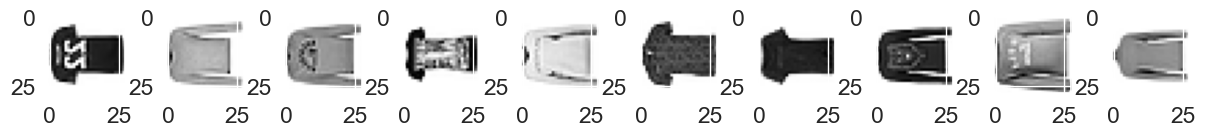

2025/02/02 13:10:03, line: 39     INFO | Client 3:


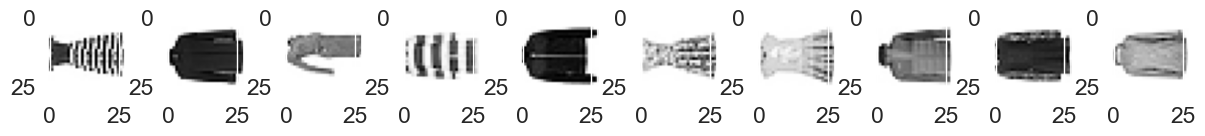

In [32]:
for client in [clients[0], clients[3]]:
    x, y = next(iter(client.train_loader))

    log.info("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
    plt.show()

2025/02/02 13:10:04, line: 39     INFO | training done for client no 2 with loss of 2.092012924194336
2025/02/02 13:10:04, line: 39     INFO | training done for client no 1 with loss of 2.0245008511925975
2025/02/02 13:10:04, line: 39     INFO | training done for client no 4 with loss of 1.4330049463220544
2025/02/02 13:10:05, line: 39     INFO | training done for client no 0 with loss of 0.9890637549580394
2025/02/02 13:10:06, line: 39     INFO | training done for client no 3 with loss of 1.0071141251004947
2025/02/02 13:10:07, line: 39     INFO | training done for client no 5 with loss of 1.5973423381605678
2025/02/02 13:10:07, line: 39     INFO | training done for client no 7 with loss of 1.334787888877888
2025/02/02 13:10:08, line: 39     INFO | training done for client no 9 with loss of 1.4268703917239576
2025/02/02 13:10:08, line: 39     INFO | training done for client no 8 with loss of 1.2989647752060587
2025/02/02 13:10:09, line: 39     INFO | training done for client no 6 with

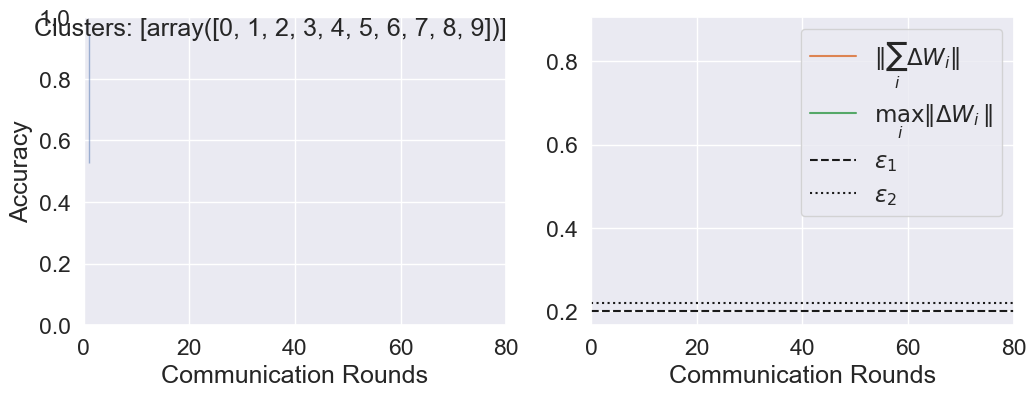

2025/02/02 13:10:10, line: 39     INFO | training done for client no 1 with loss of 1.0306646871371232
2025/02/02 13:10:10, line: 39     INFO | training done for client no 7 with loss of 0.40588893619083916
2025/02/02 13:10:12, line: 39     INFO | training done for client no 0 with loss of 0.34537665453361893
2025/02/02 13:10:12, line: 39     INFO | training done for client no 6 with loss of 0.2433362003511525
2025/02/02 13:10:14, line: 39     INFO | training done for client no 3 with loss of 0.2813646746260028
2025/02/02 13:10:14, line: 39     INFO | training done for client no 5 with loss of 0.5497442896361223
2025/02/02 13:10:15, line: 39     INFO | training done for client no 8 with loss of 0.28740169093677936
2025/02/02 13:10:15, line: 39     INFO | training done for client no 2 with loss of 1.1901807346343993
2025/02/02 13:10:16, line: 39     INFO | training done for client no 9 with loss of 0.3944289917542032
2025/02/02 13:10:17, line: 39     INFO | training done for client no 4

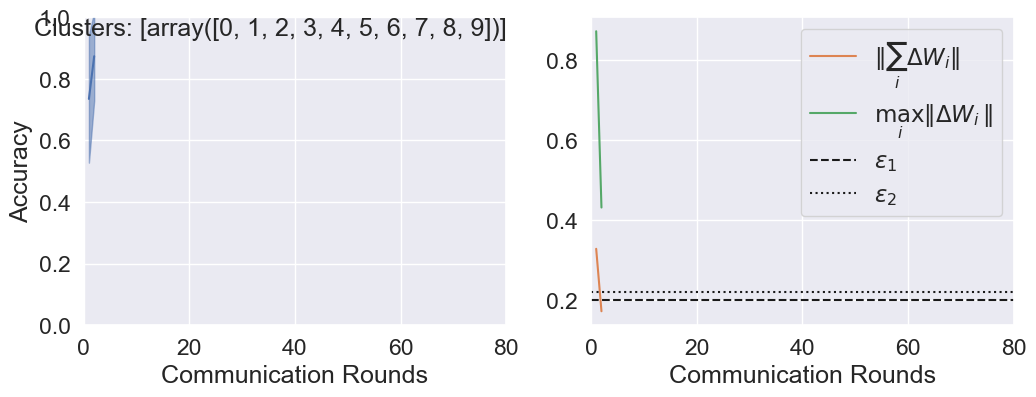

2025/02/02 13:10:19, line: 39     INFO | training done for client no 3 with loss of 0.2131193813882576
2025/02/02 13:10:19, line: 39     INFO | training done for client no 1 with loss of 0.6237387421470535
2025/02/02 13:10:20, line: 39     INFO | training done for client no 5 with loss of 0.3890757688629064
2025/02/02 13:10:21, line: 39     INFO | training done for client no 0 with loss of 0.16713059033953062
2025/02/02 13:10:22, line: 39     INFO | training done for client no 6 with loss of 0.12016122394004795
2025/02/02 13:10:23, line: 39     INFO | training done for client no 7 with loss of 0.2035654514977573
2025/02/02 13:10:23, line: 39     INFO | training done for client no 4 with loss of 0.5921622998005635
2025/02/02 13:10:25, line: 39     INFO | training done for client no 8 with loss of 0.06919239980220421
2025/02/02 13:10:25, line: 39     INFO | training done for client no 9 with loss of 0.2259893822990759
2025/02/02 13:10:26, line: 39     INFO | training done for client no 2

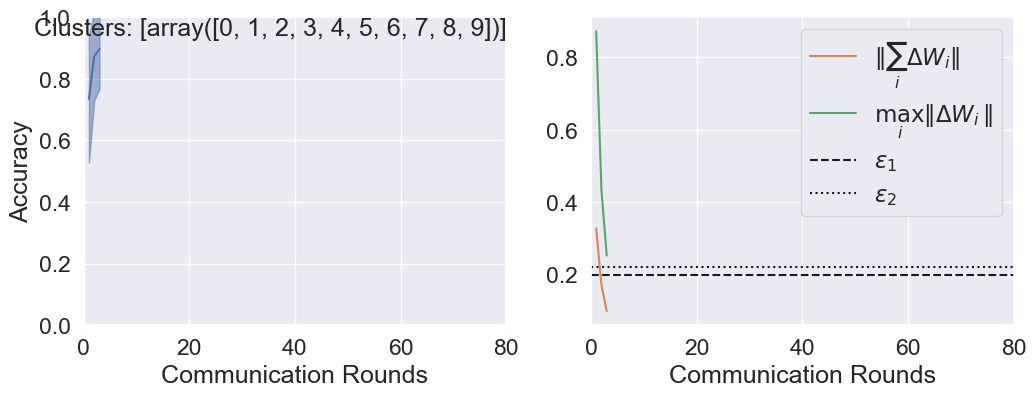

2025/02/02 13:10:27, line: 39     INFO | training done for client no 0 with loss of 0.13447648802872292
2025/02/02 13:10:28, line: 39     INFO | training done for client no 8 with loss of 0.03467789774231128
2025/02/02 13:10:30, line: 39     INFO | training done for client no 3 with loss of 0.18890858244913866
2025/02/02 13:10:31, line: 39     INFO | training done for client no 6 with loss of 0.08147777677943432
2025/02/02 13:10:31, line: 39     INFO | training done for client no 7 with loss of 0.12960551884624155
2025/02/02 13:10:32, line: 39     INFO | training done for client no 5 with loss of 0.2981827969546191
2025/02/02 13:10:32, line: 39     INFO | training done for client no 1 with loss of 0.5482369138262883
2025/02/02 13:10:33, line: 39     INFO | training done for client no 4 with loss of 0.5515970748824042
2025/02/02 13:10:34, line: 39     INFO | training done for client no 9 with loss of 0.18292243868846123
2025/02/02 13:10:34, line: 39     INFO | training done for client n

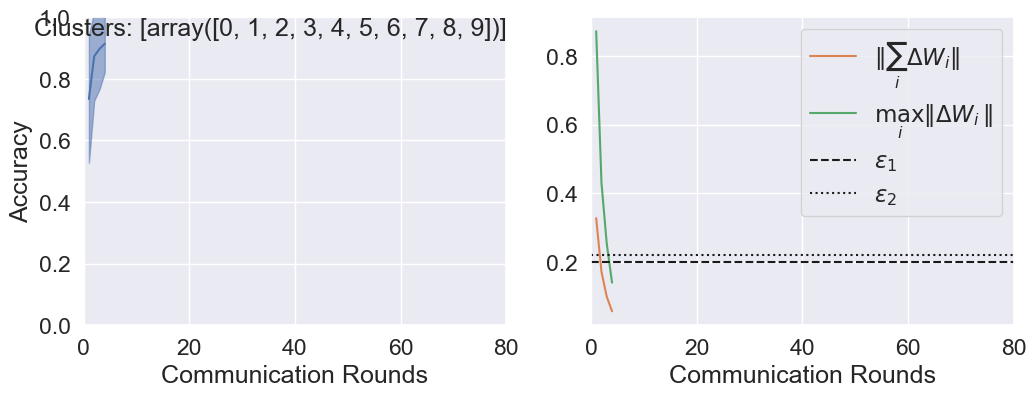

2025/02/02 13:10:35, line: 39     INFO | training done for client no 7 with loss of 0.09616450430248595
2025/02/02 13:10:36, line: 39     INFO | training done for client no 4 with loss of 0.5023259673569653
2025/02/02 13:10:38, line: 39     INFO | training done for client no 0 with loss of 0.12547347995786756
2025/02/02 13:10:39, line: 39     INFO | training done for client no 3 with loss of 0.18043137080808666
2025/02/02 13:10:40, line: 39     INFO | training done for client no 8 with loss of 0.02528830617753761
2025/02/02 13:10:41, line: 39     INFO | training done for client no 9 with loss of 0.17337092383918934
2025/02/02 13:10:41, line: 39     INFO | training done for client no 1 with loss of 0.4728350952555718
2025/02/02 13:10:41, line: 39     INFO | training done for client no 2 with loss of 0.00023970218165777623
2025/02/02 13:10:42, line: 39     INFO | training done for client no 6 with loss of 0.05967061513419893
2025/02/02 13:10:43, line: 39     INFO | training done for clie

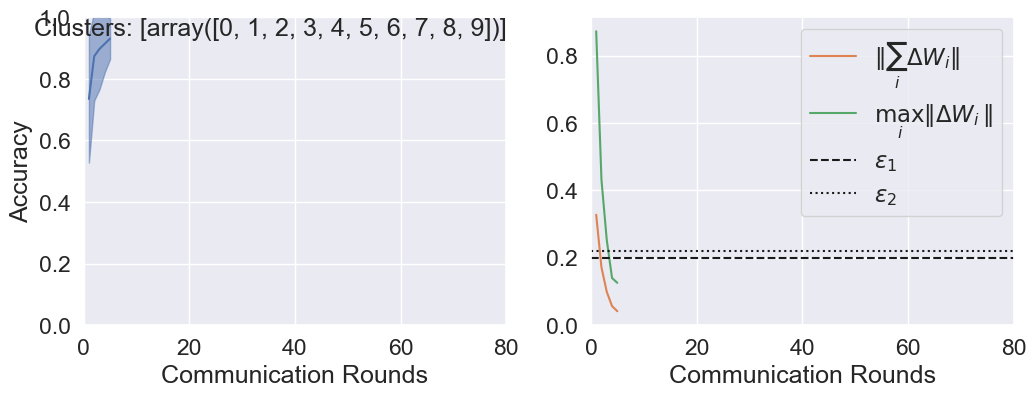

2025/02/02 13:10:44, line: 39     INFO | training done for client no 5 with loss of 0.2440735241532081
2025/02/02 13:10:45, line: 39     INFO | training done for client no 8 with loss of 0.021692272591037776
2025/02/02 13:10:46, line: 39     INFO | training done for client no 6 with loss of 0.046582415987064904
2025/02/02 13:10:47, line: 39     INFO | training done for client no 4 with loss of 0.4640720776609472
2025/02/02 13:10:48, line: 39     INFO | training done for client no 9 with loss of 0.17381619567243467
2025/02/02 13:10:48, line: 39     INFO | training done for client no 1 with loss of 0.3940941457449517
2025/02/02 13:10:48, line: 39     INFO | training done for client no 2 with loss of 7.231373753165826e-05
2025/02/02 13:10:49, line: 39     INFO | training done for client no 7 with loss of 0.0720439402358181
2025/02/02 13:10:50, line: 39     INFO | training done for client no 3 with loss of 0.15918073175798594
2025/02/02 13:10:52, line: 39     INFO | training done for clien

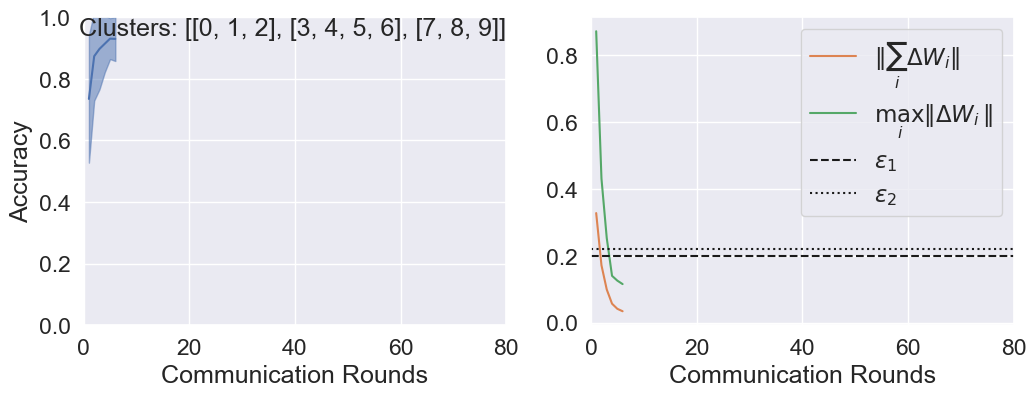

2025/02/02 13:10:53, line: 39     INFO | training done for client no 9 with loss of 0.1683945096329843
2025/02/02 13:10:54, line: 39     INFO | training done for client no 0 with loss of 0.11391635651839993
2025/02/02 13:10:55, line: 39     INFO | training done for client no 7 with loss of 0.05598910716433211
2025/02/02 13:10:55, line: 39     INFO | training done for client no 1 with loss of 0.30582272189363235
2025/02/02 13:10:56, line: 39     INFO | training done for client no 5 with loss of 0.23381024797961453
2025/02/02 13:10:57, line: 39     INFO | training done for client no 3 with loss of 0.14868681717409052
2025/02/02 13:10:58, line: 39     INFO | training done for client no 4 with loss of 0.4345111742212966
2025/02/02 13:10:58, line: 39     INFO | training done for client no 2 with loss of 3.49215412279591e-05
2025/02/02 13:10:59, line: 39     INFO | training done for client no 8 with loss of 0.018229607634462224
2025/02/02 13:11:00, line: 39     INFO | training done for clien

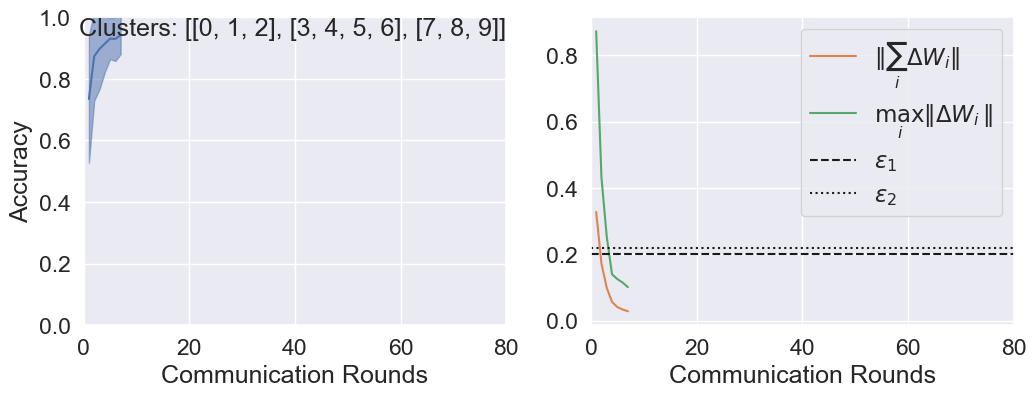

2025/02/02 13:11:02, line: 39     INFO | training done for client no 8 with loss of 0.015672440352115253
2025/02/02 13:11:02, line: 39     INFO | training done for client no 5 with loss of 0.22850026652308705
2025/02/02 13:11:03, line: 39     INFO | training done for client no 1 with loss of 0.2396294129788701
2025/02/02 13:11:04, line: 39     INFO | training done for client no 3 with loss of 0.1449006724496568
2025/02/02 13:11:05, line: 39     INFO | training done for client no 9 with loss of 0.16208332075481371
2025/02/02 13:11:06, line: 39     INFO | training done for client no 4 with loss of 0.40480205336132563
2025/02/02 13:11:07, line: 39     INFO | training done for client no 0 with loss of 0.11011852610694915
2025/02/02 13:11:08, line: 39     INFO | training done for client no 6 with loss of 0.031179230516159697
2025/02/02 13:11:09, line: 39     INFO | training done for client no 7 with loss of 0.04772680272330891
2025/02/02 13:11:09, line: 39     INFO | training done for clien

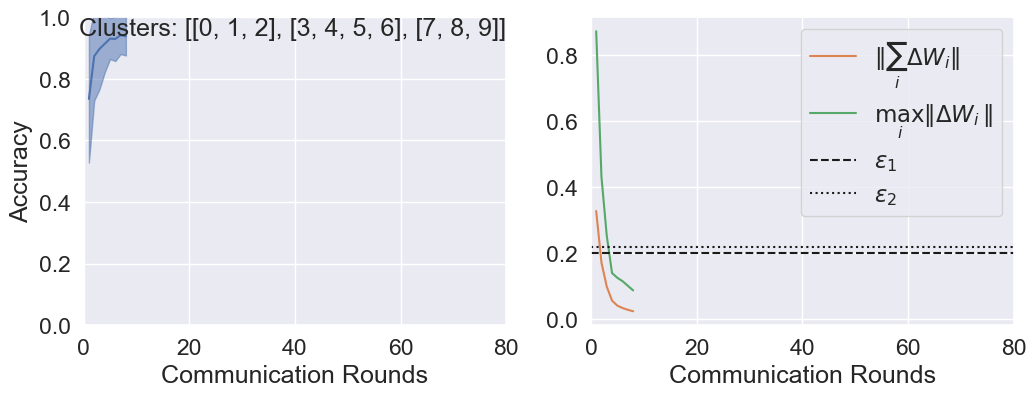

2025/02/02 13:11:10, line: 39     INFO | training done for client no 7 with loss of 0.039492537726076124
2025/02/02 13:11:12, line: 39     INFO | training done for client no 0 with loss of 0.10829642086817923
2025/02/02 13:11:12, line: 39     INFO | training done for client no 9 with loss of 0.1617424248231666
2025/02/02 13:11:14, line: 39     INFO | training done for client no 8 with loss of 0.014056490726926501
2025/02/02 13:11:14, line: 39     INFO | training done for client no 2 with loss of 1.951534501858987e-05
2025/02/02 13:11:15, line: 39     INFO | training done for client no 4 with loss of 0.38847840798867717
2025/02/02 13:11:16, line: 39     INFO | training done for client no 3 with loss of 0.13902276883256198
2025/02/02 13:11:17, line: 39     INFO | training done for client no 5 with loss of 0.2146354255857409
2025/02/02 13:11:18, line: 39     INFO | training done for client no 6 with loss of 0.027040807456247772
2025/02/02 13:11:18, line: 39     INFO | training done for cl

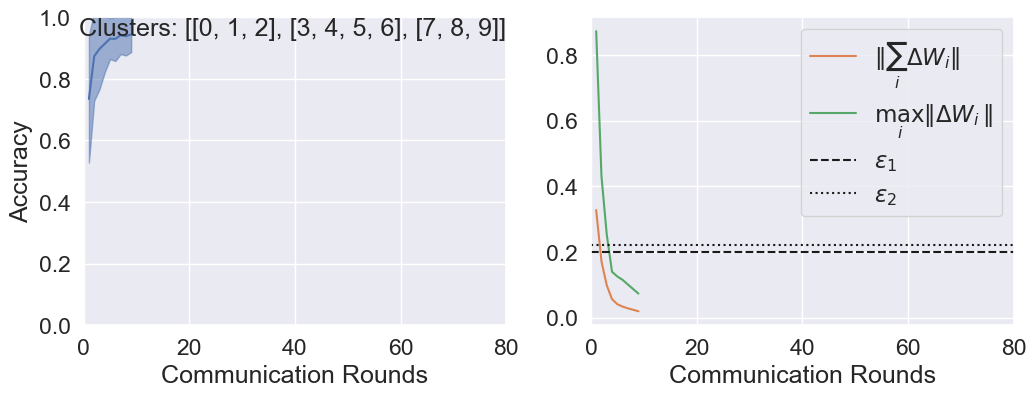

2025/02/02 13:11:19, line: 39     INFO | training done for client no 8 with loss of 0.013624847189507964
2025/02/02 13:11:21, line: 39     INFO | training done for client no 3 with loss of 0.13697606964864717
2025/02/02 13:11:22, line: 39     INFO | training done for client no 0 with loss of 0.10495775003479373
2025/02/02 13:11:23, line: 39     INFO | training done for client no 6 with loss of 0.02375337303989167
2025/02/02 13:11:23, line: 39     INFO | training done for client no 1 with loss of 0.1697935805152436
2025/02/02 13:11:24, line: 39     INFO | training done for client no 4 with loss of 0.37349183978261175
2025/02/02 13:11:25, line: 39     INFO | training done for client no 5 with loss of 0.20864463198233923
2025/02/02 13:11:26, line: 39     INFO | training done for client no 9 with loss of 0.15616968811229712
2025/02/02 13:11:26, line: 39     INFO | training done for client no 2 with loss of 1.714868363342248e-05
2025/02/02 13:11:26, line: 39     INFO | training done for cli

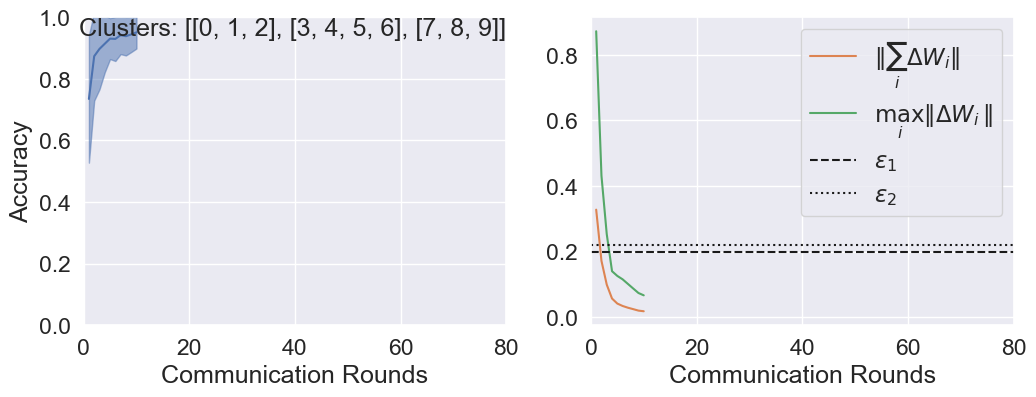

2025/02/02 13:11:28, line: 39     INFO | training done for client no 7 with loss of 0.03253039223490229
2025/02/02 13:11:28, line: 39     INFO | training done for client no 4 with loss of 0.36360251661893483
2025/02/02 13:11:30, line: 39     INFO | training done for client no 0 with loss of 0.10270854069681483
2025/02/02 13:11:31, line: 39     INFO | training done for client no 3 with loss of 0.13045632825568076
2025/02/02 13:11:32, line: 39     INFO | training done for client no 5 with loss of 0.20330980459889836
2025/02/02 13:11:33, line: 39     INFO | training done for client no 8 with loss of 0.012754596158360353
2025/02/02 13:11:33, line: 39     INFO | training done for client no 1 with loss of 0.1543532241295148
2025/02/02 13:11:33, line: 39     INFO | training done for client no 2 with loss of 1.567603964940645e-05
2025/02/02 13:11:34, line: 39     INFO | training done for client no 9 with loss of 0.15247828556589152
2025/02/02 13:11:35, line: 39     INFO | training done for cli

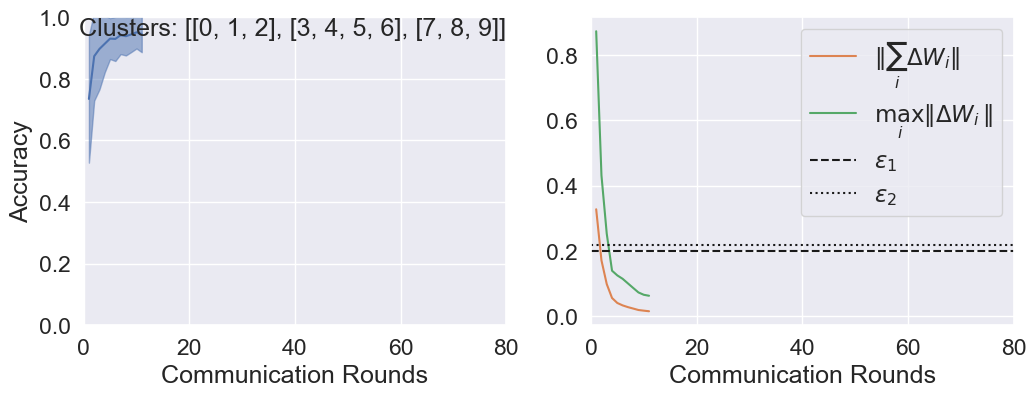

2025/02/02 13:11:37, line: 39     INFO | training done for client no 0 with loss of 0.10141025749319402
2025/02/02 13:11:38, line: 39     INFO | training done for client no 7 with loss of 0.030863910894557305
2025/02/02 13:11:38, line: 39     INFO | training done for client no 5 with loss of 0.20279255286012096
2025/02/02 13:11:39, line: 39     INFO | training done for client no 4 with loss of 0.35215834427524256
2025/02/02 13:11:40, line: 39     INFO | training done for client no 6 with loss of 0.018556543380787664
2025/02/02 13:11:40, line: 39     INFO | training done for client no 1 with loss of 0.14382549297167113
2025/02/02 13:11:41, line: 39     INFO | training done for client no 3 with loss of 0.12608271878699248
2025/02/02 13:11:42, line: 39     INFO | training done for client no 8 with loss of 0.011771864459186956
2025/02/02 13:11:43, line: 39     INFO | training done for client no 2 with loss of 1.465612850006437e-05
2025/02/02 13:11:43, line: 39     INFO | training done for 

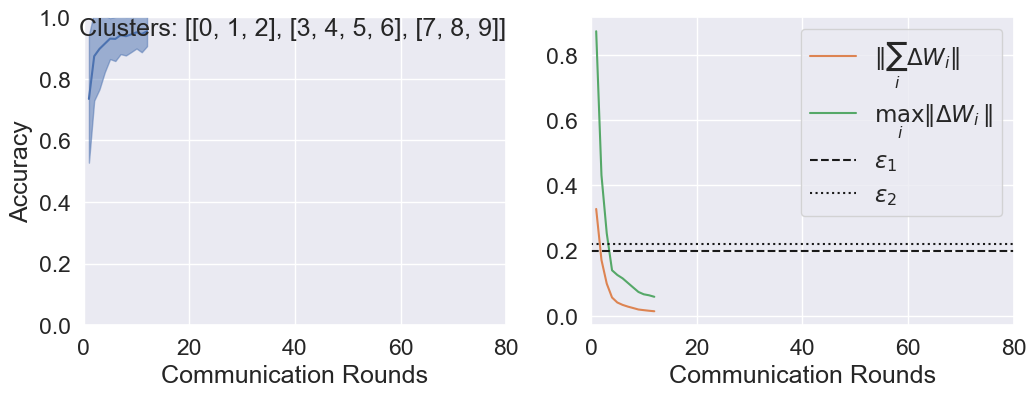

2025/02/02 13:11:44, line: 39     INFO | training done for client no 5 with loss of 0.19843038417842598
2025/02/02 13:11:46, line: 39     INFO | training done for client no 0 with loss of 0.09987418610408691
2025/02/02 13:11:46, line: 39     INFO | training done for client no 9 with loss of 0.14701119318299857
2025/02/02 13:11:48, line: 39     INFO | training done for client no 3 with loss of 0.12347477122928362
2025/02/02 13:11:48, line: 39     INFO | training done for client no 4 with loss of 0.34381409754624237
2025/02/02 13:11:50, line: 39     INFO | training done for client no 8 with loss of 0.011147834521338355
2025/02/02 13:11:50, line: 39     INFO | training done for client no 1 with loss of 0.14022409003260686
2025/02/02 13:11:50, line: 39     INFO | training done for client no 2 with loss of 1.3786773895844818e-05
2025/02/02 13:11:51, line: 39     INFO | training done for client no 7 with loss of 0.028567556282363567
2025/02/02 13:11:52, line: 39     INFO | training done for 

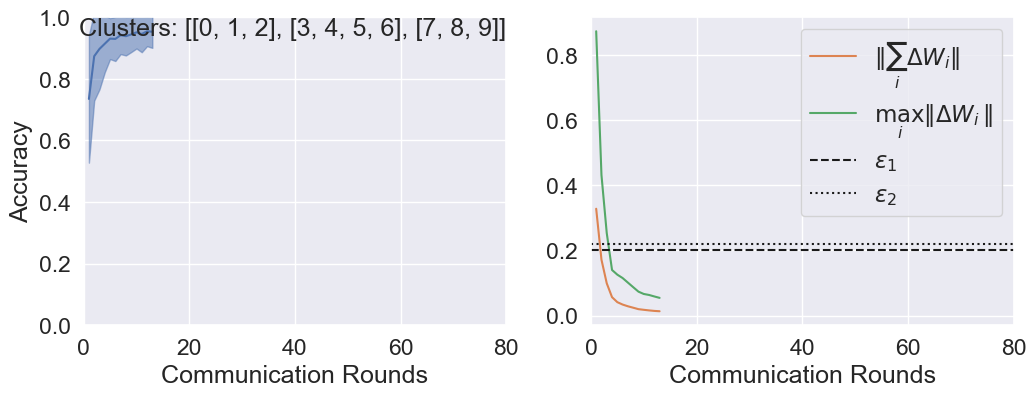

2025/02/02 13:11:52, line: 39     INFO | training done for client no 1 with loss of 0.13113028587970946
2025/02/02 13:11:53, line: 39     INFO | training done for client no 8 with loss of 0.010690599662990557
2025/02/02 13:11:54, line: 39     INFO | training done for client no 4 with loss of 0.33276773868380366
2025/02/02 13:11:55, line: 39     INFO | training done for client no 0 with loss of 0.09792286157155988
2025/02/02 13:11:56, line: 39     INFO | training done for client no 5 with loss of 0.18320626653807365
2025/02/02 13:11:57, line: 39     INFO | training done for client no 6 with loss of 0.015364629959246298
2025/02/02 13:11:58, line: 39     INFO | training done for client no 7 with loss of 0.026903391861421405
2025/02/02 13:11:59, line: 39     INFO | training done for client no 3 with loss of 0.12441090801084033
2025/02/02 13:12:00, line: 39     INFO | training done for client no 9 with loss of 0.14185028036137048
2025/02/02 13:12:00, line: 39     INFO | training done for cl

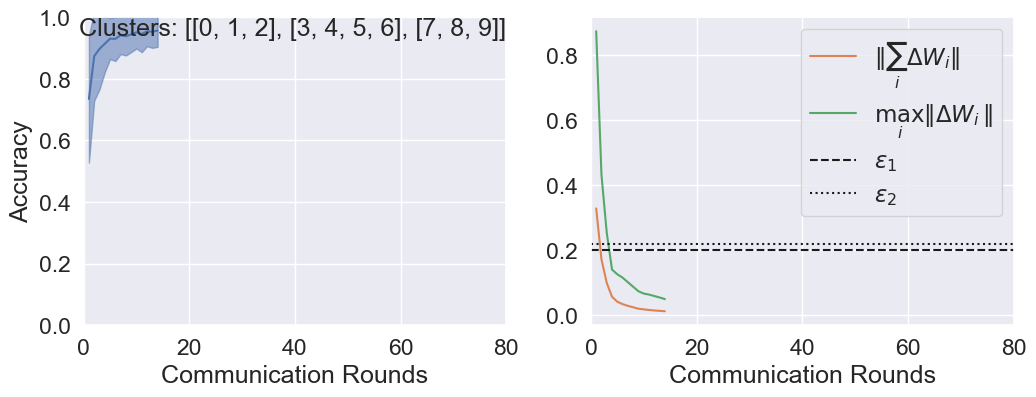

2025/02/02 13:12:01, line: 39     INFO | training done for client no 4 with loss of 0.33237788725543665
2025/02/02 13:12:03, line: 39     INFO | training done for client no 3 with loss of 0.12430740020633133
2025/02/02 13:12:03, line: 39     INFO | training done for client no 9 with loss of 0.13972790293087797
2025/02/02 13:12:05, line: 39     INFO | training done for client no 0 with loss of 0.09765633485579343
2025/02/02 13:12:06, line: 39     INFO | training done for client no 7 with loss of 0.026212826530352965
2025/02/02 13:12:06, line: 39     INFO | training done for client no 1 with loss of 0.12546487197096612
2025/02/02 13:12:06, line: 39     INFO | training done for client no 2 with loss of 1.2989533919608221e-05
2025/02/02 13:12:07, line: 39     INFO | training done for client no 5 with loss of 0.18230000643147581
2025/02/02 13:12:08, line: 39     INFO | training done for client no 6 with loss of 0.014086588403098392
2025/02/02 13:12:09, line: 39     INFO | training done for 

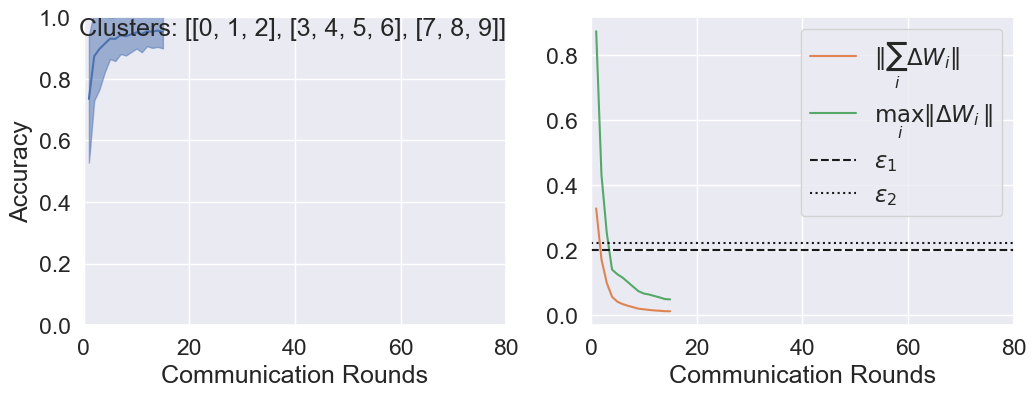

2025/02/02 13:12:09, line: 39     INFO | training done for client no 2 with loss of 1.2987864087335766e-05
2025/02/02 13:12:10, line: 39     INFO | training done for client no 4 with loss of 0.3280474608008926
2025/02/02 13:12:11, line: 39     INFO | training done for client no 9 with loss of 0.1363637337758733
2025/02/02 13:12:12, line: 39     INFO | training done for client no 5 with loss of 0.17609288012589763
2025/02/02 13:12:13, line: 39     INFO | training done for client no 7 with loss of 0.02517024285669002
2025/02/02 13:12:13, line: 39     INFO | training done for client no 6 with loss of 0.013107043158481843
2025/02/02 13:12:15, line: 39     INFO | training done for client no 3 with loss of 0.11903452431686422
2025/02/02 13:12:16, line: 39     INFO | training done for client no 8 with loss of 0.009890140921822636
2025/02/02 13:12:16, line: 39     INFO | training done for client no 1 with loss of 0.12321519933741346
2025/02/02 13:12:18, line: 39     INFO | training done for cl

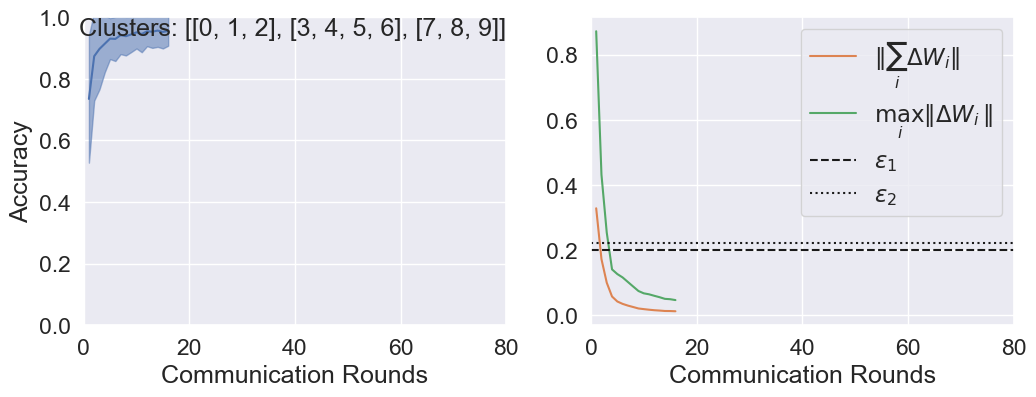

2025/02/02 13:12:19, line: 39     INFO | training done for client no 7 with loss of 0.024370384741379123
2025/02/02 13:12:19, line: 39     INFO | training done for client no 1 with loss of 0.11792534478685279
2025/02/02 13:12:21, line: 39     INFO | training done for client no 0 with loss of 0.0944323562797145
2025/02/02 13:12:21, line: 39     INFO | training done for client no 2 with loss of 1.2541803349449765e-05
2025/02/02 13:12:22, line: 39     INFO | training done for client no 3 with loss of 0.11611140767608737
2025/02/02 13:12:23, line: 39     INFO | training done for client no 6 with loss of 0.012837084709067645
2025/02/02 13:12:24, line: 39     INFO | training done for client no 5 with loss of 0.17316918717639893
2025/02/02 13:12:25, line: 39     INFO | training done for client no 9 with loss of 0.1333078578935099
2025/02/02 13:12:26, line: 39     INFO | training done for client no 8 with loss of 0.009945780179443635
2025/02/02 13:12:27, line: 39     INFO | training done for c

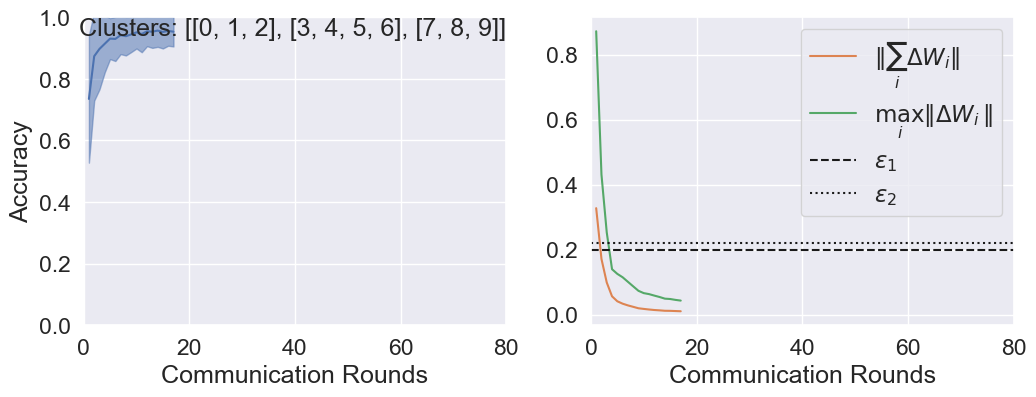

2025/02/02 13:12:28, line: 39     INFO | training done for client no 4 with loss of 0.3171420516194524
2025/02/02 13:12:29, line: 39     INFO | training done for client no 8 with loss of 0.009911223997988432
2025/02/02 13:12:30, line: 39     INFO | training done for client no 3 with loss of 0.11451139925087446
2025/02/02 13:12:31, line: 39     INFO | training done for client no 9 with loss of 0.13059042215123493
2025/02/02 13:12:32, line: 39     INFO | training done for client no 7 with loss of 0.02430110929656755
2025/02/02 13:12:34, line: 39     INFO | training done for client no 0 with loss of 0.09327984470257032
2025/02/02 13:12:34, line: 39     INFO | training done for client no 1 with loss of 0.11554076550522951
2025/02/02 13:12:35, line: 39     INFO | training done for client no 6 with loss of 0.01174276391790602
2025/02/02 13:12:35, line: 39     INFO | training done for client no 5 with loss of 0.16817723373735222
2025/02/02 13:12:36, line: 39     INFO | training done for clien

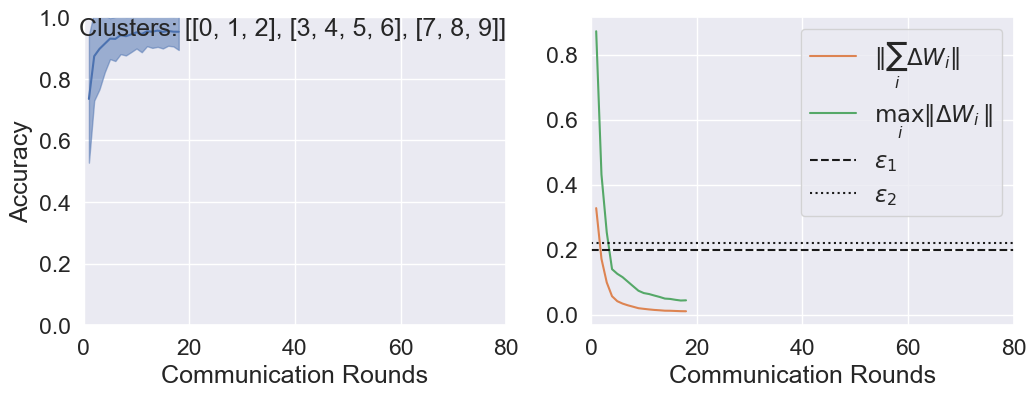

2025/02/02 13:12:38, line: 39     INFO | training done for client no 0 with loss of 0.09330737260798057
2025/02/02 13:12:38, line: 39     INFO | training done for client no 2 with loss of 1.2072852274286561e-05
2025/02/02 13:12:39, line: 39     INFO | training done for client no 7 with loss of 0.023871016923445332
2025/02/02 13:12:39, line: 39     INFO | training done for client no 5 with loss of 0.16463882174702396
2025/02/02 13:12:40, line: 39     INFO | training done for client no 4 with loss of 0.3167257735858092
2025/02/02 13:12:42, line: 39     INFO | training done for client no 3 with loss of 0.11775036037013058
2025/02/02 13:12:42, line: 39     INFO | training done for client no 1 with loss of 0.11155036716832707
2025/02/02 13:12:43, line: 39     INFO | training done for client no 8 with loss of 0.009314628314670283
2025/02/02 13:12:44, line: 39     INFO | training done for client no 6 with loss of 0.010854380212672814
2025/02/02 13:12:45, line: 39     INFO | training done for 

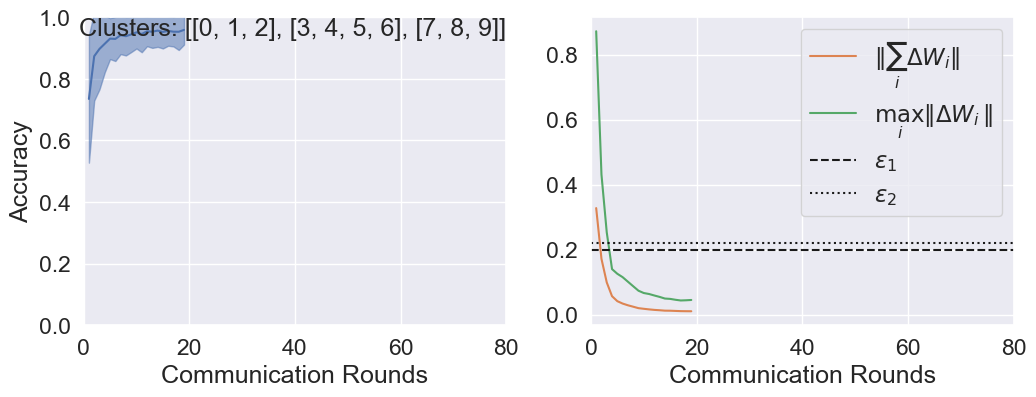

2025/02/02 13:12:46, line: 39     INFO | training done for client no 8 with loss of 0.009197524216696298
2025/02/02 13:12:48, line: 39     INFO | training done for client no 0 with loss of 0.09138620103124116
2025/02/02 13:12:49, line: 39     INFO | training done for client no 6 with loss of 0.01019773365917317
2025/02/02 13:12:49, line: 39     INFO | training done for client no 5 with loss of 0.1630828637147831
2025/02/02 13:12:50, line: 39     INFO | training done for client no 4 with loss of 0.30350334217419495
2025/02/02 13:12:50, line: 39     INFO | training done for client no 2 with loss of 1.1722748757165391e-05
2025/02/02 13:12:52, line: 39     INFO | training done for client no 3 with loss of 0.11470188513887529
2025/02/02 13:12:53, line: 39     INFO | training done for client no 9 with loss of 0.12584164038045634
2025/02/02 13:12:53, line: 39     INFO | training done for client no 1 with loss of 0.11147164620402339
2025/02/02 13:12:54, line: 39     INFO | training done for cl

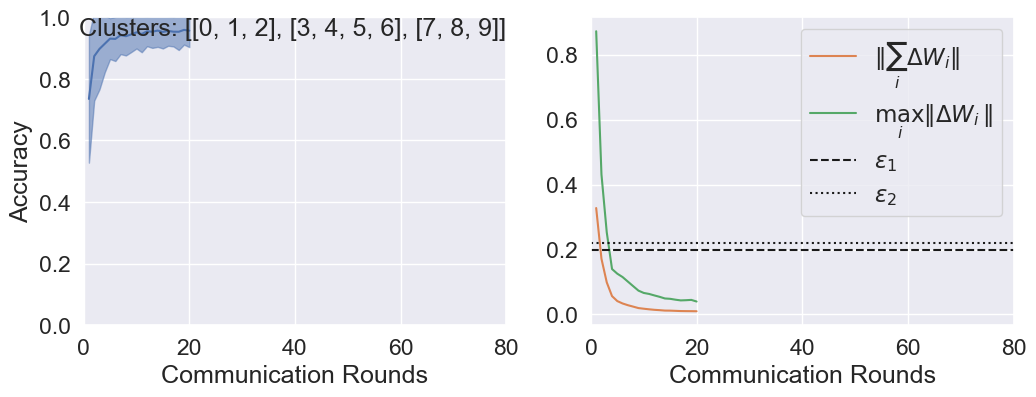

2025/02/02 13:12:56, line: 39     INFO | training done for client no 3 with loss of 0.12069280911026876
2025/02/02 13:12:59, line: 39     INFO | training done for client no 0 with loss of 0.09224137070127345
2025/02/02 13:13:00, line: 39     INFO | training done for client no 4 with loss of 0.2998868726395272
2025/02/02 13:13:01, line: 39     INFO | training done for client no 8 with loss of 0.008667709992304385
2025/02/02 13:13:02, line: 39     INFO | training done for client no 6 with loss of 0.010489665105700543
2025/02/02 13:13:02, line: 39     INFO | training done for client no 2 with loss of 1.1435943422839045e-05
2025/02/02 13:13:03, line: 39     INFO | training done for client no 7 with loss of 0.0221496695942559
2025/02/02 13:13:03, line: 39     INFO | training done for client no 9 with loss of 0.12458089324127002
2025/02/02 13:13:04, line: 39     INFO | training done for client no 5 with loss of 0.15620350063581487
2025/02/02 13:13:04, line: 39     INFO | training done for cl

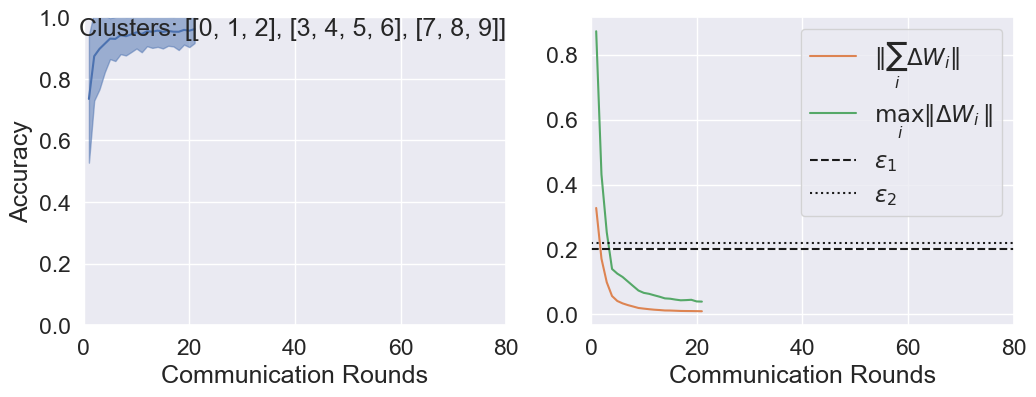

2025/02/02 13:13:05, line: 39     INFO | training done for client no 9 with loss of 0.12063958685772092
2025/02/02 13:13:06, line: 39     INFO | training done for client no 4 with loss of 0.2993072078034684
2025/02/02 13:13:06, line: 39     INFO | training done for client no 2 with loss of 1.1433440216933377e-05
2025/02/02 13:13:07, line: 39     INFO | training done for client no 0 with loss of 0.09006352227385972
2025/02/02 13:13:09, line: 39     INFO | training done for client no 8 with loss of 0.00857844348696404
2025/02/02 13:13:09, line: 39     INFO | training done for client no 6 with loss of 0.009229141231369295
2025/02/02 13:13:10, line: 39     INFO | training done for client no 1 with loss of 0.10543786369451809
2025/02/02 13:13:11, line: 39     INFO | training done for client no 7 with loss of 0.021713656976869465
2025/02/02 13:13:12, line: 39     INFO | training done for client no 3 with loss of 0.11246909053777208
2025/02/02 13:13:12, line: 39     INFO | training done for c

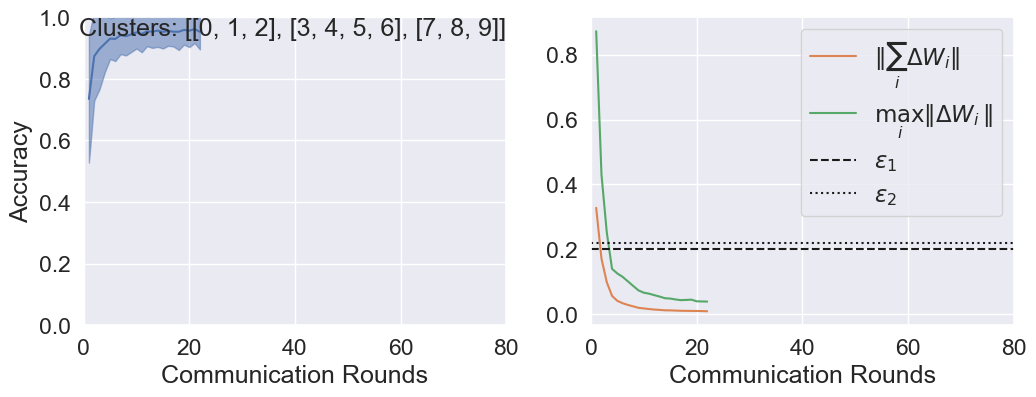

2025/02/02 13:13:14, line: 39     INFO | training done for client no 9 with loss of 0.11788582233001055
2025/02/02 13:13:15, line: 39     INFO | training done for client no 8 with loss of 0.008252954467279238
2025/02/02 13:13:16, line: 39     INFO | training done for client no 0 with loss of 0.0897195724741722
2025/02/02 13:13:18, line: 39     INFO | training done for client no 3 with loss of 0.11575897484009175
2025/02/02 13:13:18, line: 39     INFO | training done for client no 1 with loss of 0.10338623660458901
2025/02/02 13:13:18, line: 39     INFO | training done for client no 2 with loss of 1.1365254955308046e-05
2025/02/02 13:13:19, line: 39     INFO | training done for client no 7 with loss of 0.02185759116626028
2025/02/02 13:13:20, line: 39     INFO | training done for client no 6 with loss of 0.009117365604732629
2025/02/02 13:13:20, line: 39     INFO | training done for client no 5 with loss of 0.1539726667947593
2025/02/02 13:13:21, line: 39     INFO | training done for cl

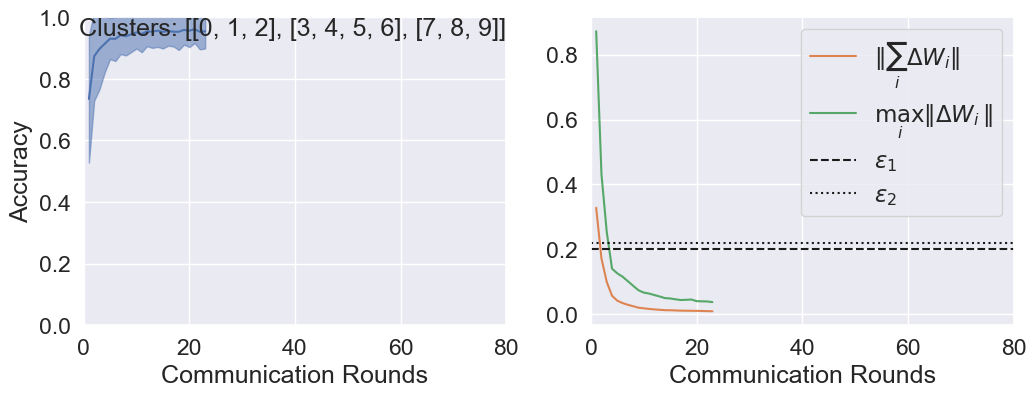

2025/02/02 13:13:22, line: 39     INFO | training done for client no 7 with loss of 0.020598954844167187
2025/02/02 13:13:23, line: 39     INFO | training done for client no 1 with loss of 0.10050781694904852
2025/02/02 13:13:24, line: 39     INFO | training done for client no 6 with loss of 0.008345720375383841
2025/02/02 13:13:24, line: 39     INFO | training done for client no 2 with loss of 1.1119813680124934e-05
2025/02/02 13:13:25, line: 39     INFO | training done for client no 4 with loss of 0.2940870011980469
2025/02/02 13:13:26, line: 39     INFO | training done for client no 3 with loss of 0.11220648906252742
2025/02/02 13:13:28, line: 39     INFO | training done for client no 0 with loss of 0.08855093588439814
2025/02/02 13:13:29, line: 39     INFO | training done for client no 8 with loss of 0.008243979895655168
2025/02/02 13:13:30, line: 39     INFO | training done for client no 9 with loss of 0.11592926903719897
2025/02/02 13:13:30, line: 39     INFO | training done for 

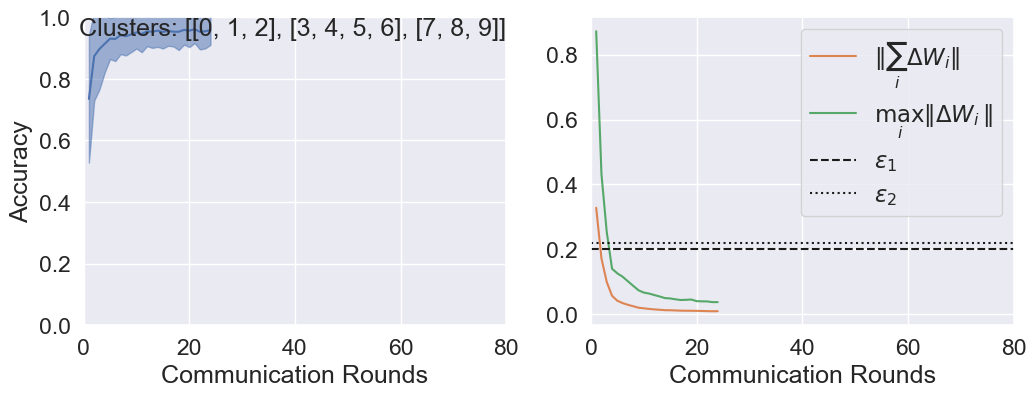

2025/02/02 13:13:32, line: 39     INFO | training done for client no 0 with loss of 0.08774698080494774
2025/02/02 13:13:32, line: 39     INFO | training done for client no 2 with loss of 1.1083337121817748e-05
2025/02/02 13:13:34, line: 39     INFO | training done for client no 3 with loss of 0.11362198807950993
2025/02/02 13:13:35, line: 39     INFO | training done for client no 6 with loss of 0.008221357213386416
2025/02/02 13:13:36, line: 39     INFO | training done for client no 8 with loss of 0.007792659384725774
2025/02/02 13:13:37, line: 39     INFO | training done for client no 4 with loss of 0.2904700616727004
2025/02/02 13:13:37, line: 39     INFO | training done for client no 1 with loss of 0.100694936973506
2025/02/02 13:13:38, line: 39     INFO | training done for client no 7 with loss of 0.02091624227536814
2025/02/02 13:13:38, line: 39     INFO | training done for client no 5 with loss of 0.15056261655853515
2025/02/02 13:13:39, line: 39     INFO | training done for cli

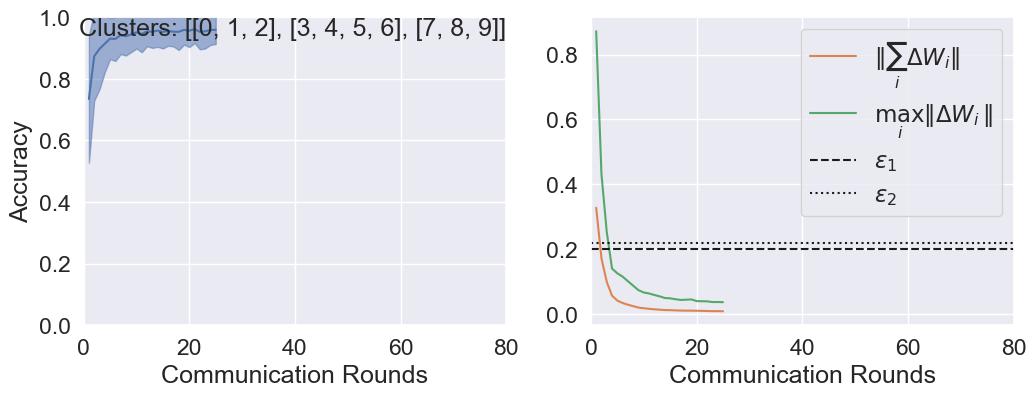

2025/02/02 13:13:40, line: 39     INFO | training done for client no 4 with loss of 0.2838615199198594
2025/02/02 13:13:41, line: 39     INFO | training done for client no 1 with loss of 0.10024951535206687
2025/02/02 13:13:42, line: 39     INFO | training done for client no 6 with loss of 0.007862226034472071
2025/02/02 13:13:43, line: 39     INFO | training done for client no 9 with loss of 0.11312772664344455
2025/02/02 13:13:43, line: 39     INFO | training done for client no 2 with loss of 1.066540624742629e-05
2025/02/02 13:13:44, line: 39     INFO | training done for client no 7 with loss of 0.020123927609746024
2025/02/02 13:13:45, line: 39     INFO | training done for client no 3 with loss of 0.1108596475277069
2025/02/02 13:13:46, line: 39     INFO | training done for client no 5 with loss of 0.1435669947576229
2025/02/02 13:13:47, line: 39     INFO | training done for client no 0 with loss of 0.08849672811640841
2025/02/02 13:13:48, line: 39     INFO | training done for clie

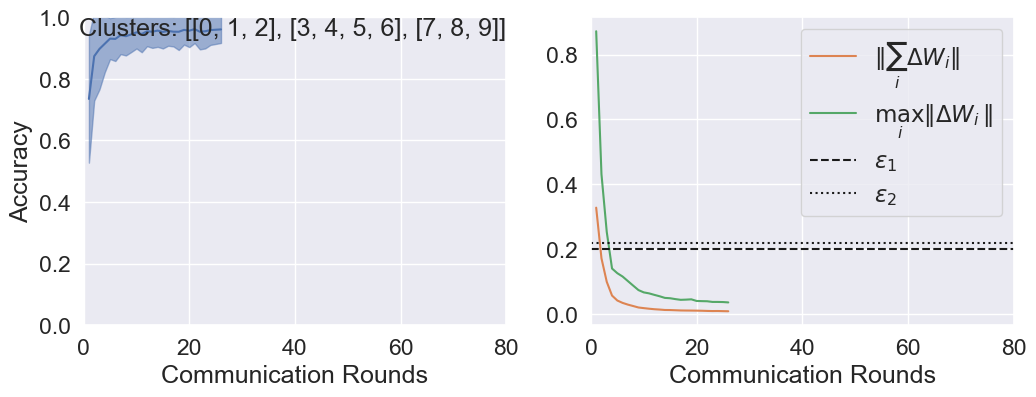

2025/02/02 13:13:50, line: 39     INFO | training done for client no 0 with loss of 0.08855568155322661
2025/02/02 13:13:50, line: 39     INFO | training done for client no 1 with loss of 0.09735173787474283
2025/02/02 13:13:51, line: 39     INFO | training done for client no 2 with loss of 1.0617605948937125e-05
2025/02/02 13:13:52, line: 39     INFO | training done for client no 8 with loss of 0.007443226503241827
2025/02/02 13:13:53, line: 39     INFO | training done for client no 6 with loss of 0.00766756246446833
2025/02/02 13:13:53, line: 39     INFO | training done for client no 4 with loss of 0.2938183904499621
2025/02/02 13:13:54, line: 39     INFO | training done for client no 5 with loss of 0.14208922181775682
2025/02/02 13:13:56, line: 39     INFO | training done for client no 3 with loss of 0.1079813080918493
2025/02/02 13:13:56, line: 39     INFO | training done for client no 7 with loss of 0.020207015781737423
2025/02/02 13:13:57, line: 39     INFO | training done for cl

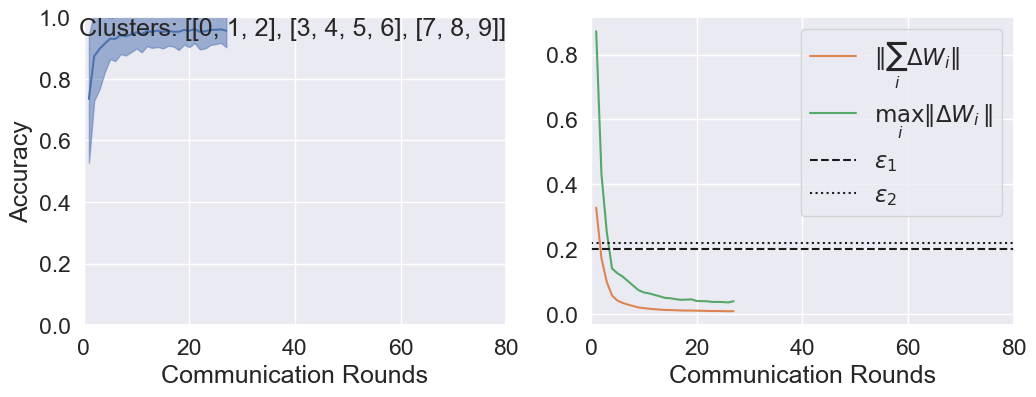

2025/02/02 13:13:58, line: 39     INFO | training done for client no 5 with loss of 0.1397379890726822
2025/02/02 13:13:59, line: 39     INFO | training done for client no 9 with loss of 0.10518062575675569
2025/02/02 13:14:01, line: 39     INFO | training done for client no 8 with loss of 0.0074162001809806866
2025/02/02 13:14:02, line: 39     INFO | training done for client no 0 with loss of 0.0863577542719625
2025/02/02 13:14:02, line: 39     INFO | training done for client no 2 with loss of 1.0831934618181548e-05
2025/02/02 13:14:02, line: 39     INFO | training done for client no 1 with loss of 0.09484302168291915
2025/02/02 13:14:04, line: 39     INFO | training done for client no 3 with loss of 0.1067734581896254
2025/02/02 13:14:05, line: 39     INFO | training done for client no 6 with loss of 0.007198931962352682
2025/02/02 13:14:05, line: 39     INFO | training done for client no 7 with loss of 0.020044231751079587
2025/02/02 13:14:06, line: 39     INFO | training done for c

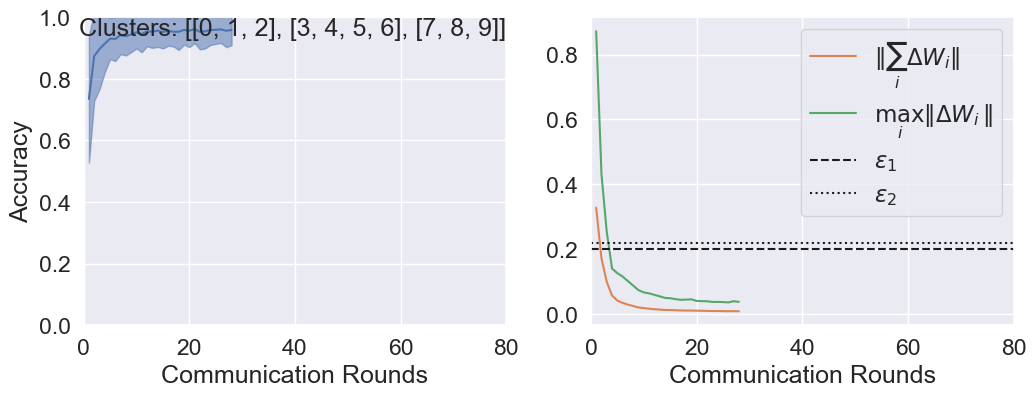

2025/02/02 13:14:08, line: 39     INFO | training done for client no 0 with loss of 0.08503251497239009
2025/02/02 13:14:09, line: 39     INFO | training done for client no 6 with loss of 0.007016315389172902
2025/02/02 13:14:09, line: 39     INFO | training done for client no 1 with loss of 0.0946754452035346
2025/02/02 13:14:11, line: 39     INFO | training done for client no 3 with loss of 0.10521712320942901
2025/02/02 13:14:11, line: 39     INFO | training done for client no 7 with loss of 0.019426935961447945
2025/02/02 13:14:12, line: 39     INFO | training done for client no 5 with loss of 0.13834275185939468
2025/02/02 13:14:12, line: 39     INFO | training done for client no 2 with loss of 1.0480162760359235e-05
2025/02/02 13:14:13, line: 39     INFO | training done for client no 9 with loss of 0.10351032373628669
2025/02/02 13:14:14, line: 39     INFO | training done for client no 4 with loss of 0.2743684109803793
2025/02/02 13:14:15, line: 39     INFO | training done for cl

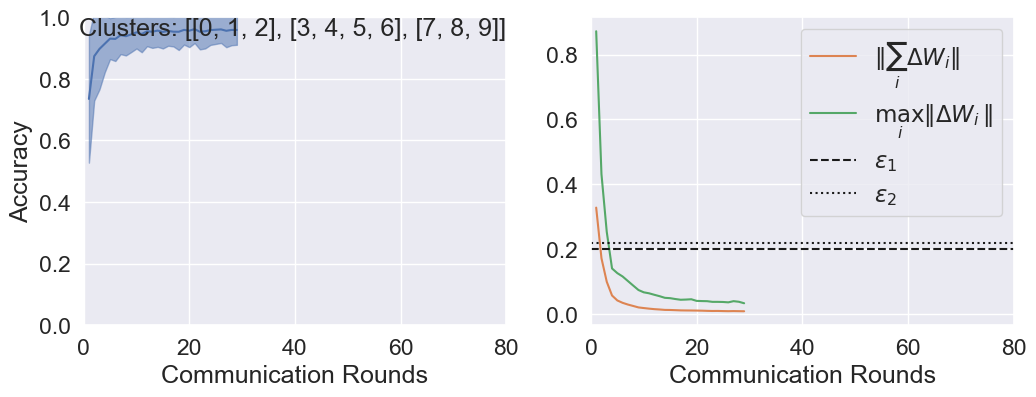

2025/02/02 13:14:16, line: 39     INFO | training done for client no 9 with loss of 0.10268132235663704
2025/02/02 13:14:17, line: 39     INFO | training done for client no 8 with loss of 0.007388068074922055
2025/02/02 13:14:18, line: 39     INFO | training done for client no 3 with loss of 0.10502640097421881
2025/02/02 13:14:19, line: 39     INFO | training done for client no 4 with loss of 0.2735004566005758
2025/02/02 13:14:20, line: 39     INFO | training done for client no 0 with loss of 0.08497281281867228
2025/02/02 13:14:21, line: 39     INFO | training done for client no 2 with loss of 1.0618797590723262e-05
2025/02/02 13:14:21, line: 39     INFO | training done for client no 6 with loss of 0.006901463060749319
2025/02/02 13:14:22, line: 39     INFO | training done for client no 1 with loss of 0.09284353858557233
2025/02/02 13:14:22, line: 39     INFO | training done for client no 5 with loss of 0.1354561103871226
2025/02/02 13:14:23, line: 39     INFO | training done for cl

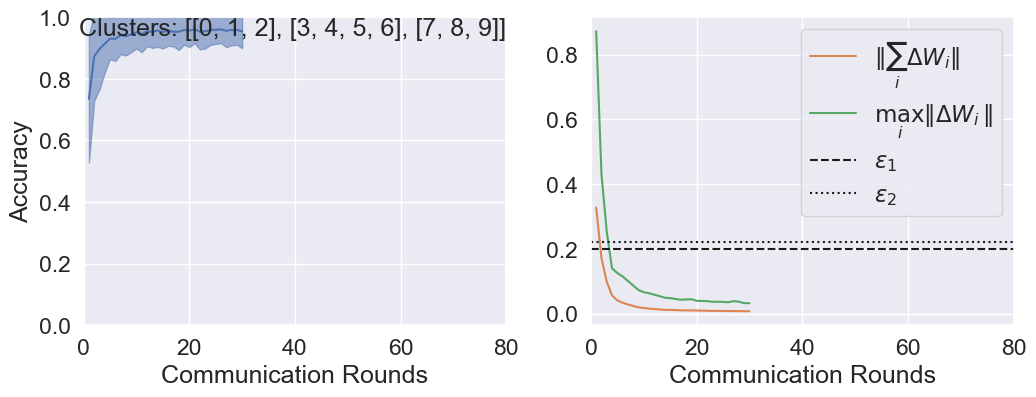

2025/02/02 13:14:24, line: 39     INFO | training done for client no 4 with loss of 0.2665123645518277
2025/02/02 13:14:25, line: 39     INFO | training done for client no 1 with loss of 0.09292747931883359
2025/02/02 13:14:26, line: 39     INFO | training done for client no 0 with loss of 0.08425609050496026
2025/02/02 13:14:27, line: 39     INFO | training done for client no 6 with loss of 0.0063713196647326
2025/02/02 13:14:27, line: 39     INFO | training done for client no 2 with loss of 1.0399937491456512e-05
2025/02/02 13:14:28, line: 39     INFO | training done for client no 7 with loss of 0.01917360131132421
2025/02/02 13:14:29, line: 39     INFO | training done for client no 9 with loss of 0.10085104845548154
2025/02/02 13:14:31, line: 39     INFO | training done for client no 3 with loss of 0.10469391832198675
2025/02/02 13:14:32, line: 39     INFO | training done for client no 8 with loss of 0.006805537022588615
2025/02/02 13:14:32, line: 39     INFO | training done for cli

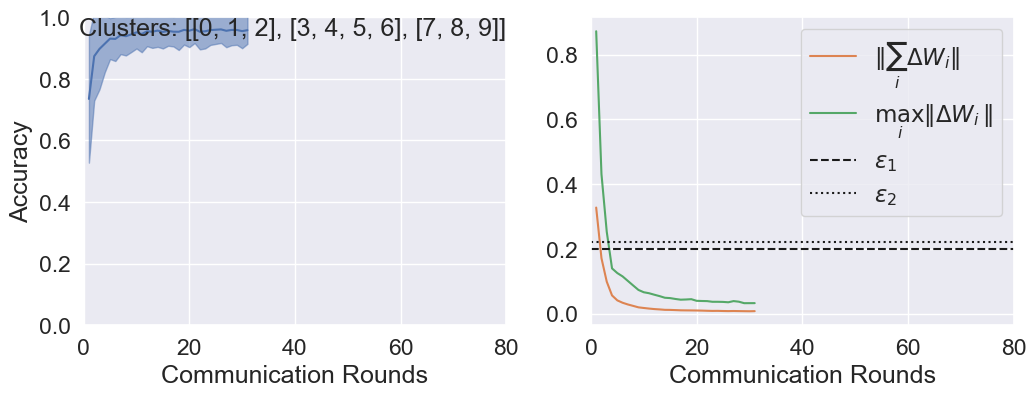

2025/02/02 13:14:34, line: 39     INFO | training done for client no 0 with loss of 0.0844273651582663
2025/02/02 13:14:36, line: 39     INFO | training done for client no 3 with loss of 0.10455456980489854
2025/02/02 13:14:37, line: 39     INFO | training done for client no 8 with loss of 0.006969729888769992
2025/02/02 13:14:38, line: 39     INFO | training done for client no 6 with loss of 0.0062464752016309025
2025/02/02 13:14:38, line: 39     INFO | training done for client no 4 with loss of 0.2670520962895574
2025/02/02 13:14:39, line: 39     INFO | training done for client no 7 with loss of 0.0189088068070448
2025/02/02 13:14:40, line: 39     INFO | training done for client no 1 with loss of 0.0973039875881813
2025/02/02 13:14:40, line: 39     INFO | training done for client no 9 with loss of 0.10275645283333301
2025/02/02 13:14:41, line: 39     INFO | training done for client no 5 with loss of 0.13128358619842195
2025/02/02 13:14:41, line: 39     INFO | training done for client

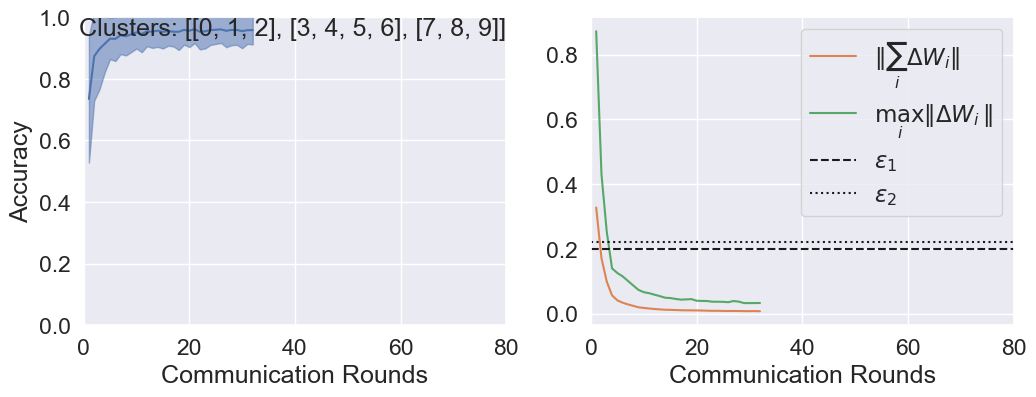

2025/02/02 13:14:43, line: 39     INFO | training done for client no 3 with loss of 0.10959241958556841
2025/02/02 13:14:43, line: 39     INFO | training done for client no 2 with loss of 1.0014906372816767e-05
2025/02/02 13:14:43, line: 39     INFO | training done for client no 1 with loss of 0.09298196403548671
2025/02/02 13:14:44, line: 39     INFO | training done for client no 9 with loss of 0.09696503539954716
2025/02/02 13:14:45, line: 39     INFO | training done for client no 6 with loss of 0.005929433813958396
2025/02/02 13:14:46, line: 39     INFO | training done for client no 4 with loss of 0.2688146736976263
2025/02/02 13:14:47, line: 39     INFO | training done for client no 8 with loss of 0.006893593412984422
2025/02/02 13:14:48, line: 39     INFO | training done for client no 5 with loss of 0.1322442591190338
2025/02/02 13:14:49, line: 39     INFO | training done for client no 7 with loss of 0.01916501697234797
2025/02/02 13:14:50, line: 39     INFO | training done for cl

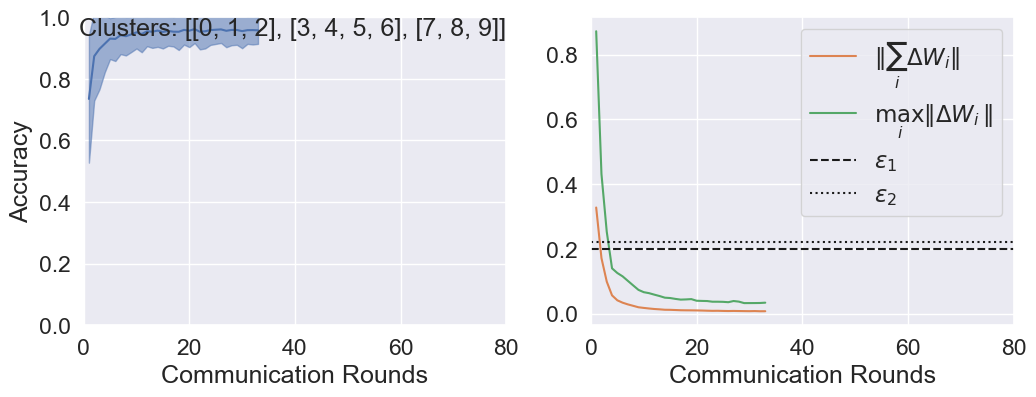

2025/02/02 13:14:51, line: 39     INFO | training done for client no 5 with loss of 0.13292537844554356
2025/02/02 13:14:51, line: 39     INFO | training done for client no 1 with loss of 0.0876436575671072
2025/02/02 13:14:53, line: 39     INFO | training done for client no 3 with loss of 0.10187299836470866
2025/02/02 13:14:53, line: 39     INFO | training done for client no 9 with loss of 0.09623105892376149
2025/02/02 13:14:54, line: 39     INFO | training done for client no 2 with loss of 1.0352971439715475e-05
2025/02/02 13:14:55, line: 39     INFO | training done for client no 0 with loss of 0.08313930871776767
2025/02/02 13:14:56, line: 39     INFO | training done for client no 4 with loss of 0.26777558149518194
2025/02/02 13:14:57, line: 39     INFO | training done for client no 7 with loss of 0.018603952644887664
2025/02/02 13:14:58, line: 39     INFO | training done for client no 8 with loss of 0.007136736932001314
2025/02/02 13:14:59, line: 39     INFO | training done for c

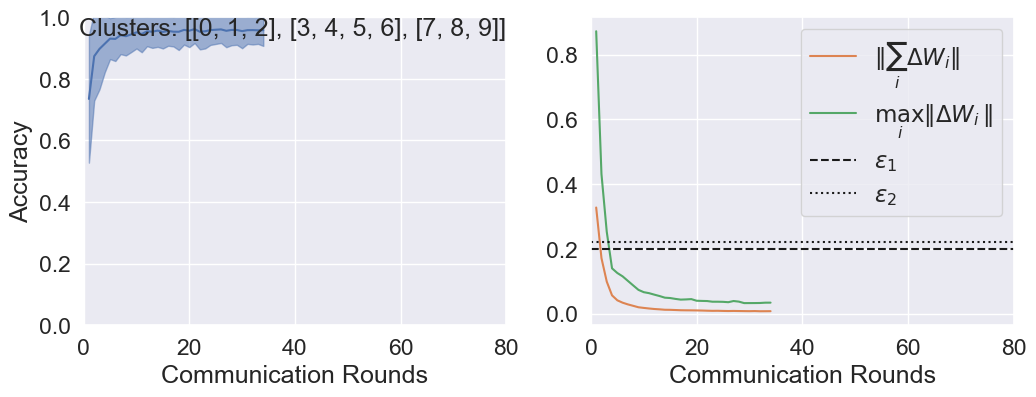

2025/02/02 13:15:00, line: 39     INFO | training done for client no 7 with loss of 0.0185595725366748
2025/02/02 13:15:01, line: 39     INFO | training done for client no 6 with loss of 0.0056241795118476354
2025/02/02 13:15:01, line: 39     INFO | training done for client no 5 with loss of 0.13127275954098183
2025/02/02 13:15:03, line: 39     INFO | training done for client no 3 with loss of 0.10411445777251566
2025/02/02 13:15:04, line: 39     INFO | training done for client no 0 with loss of 0.0824028383219449
2025/02/02 13:15:05, line: 39     INFO | training done for client no 9 with loss of 0.09345723511740522
2025/02/02 13:15:05, line: 39     INFO | training done for client no 2 with loss of 1.013732906721998e-05
2025/02/02 13:15:06, line: 39     INFO | training done for client no 8 with loss of 0.006414978346767702
2025/02/02 13:15:06, line: 39     INFO | training done for client no 1 with loss of 0.08749244175742227
2025/02/02 13:15:07, line: 39     INFO | training done for cl

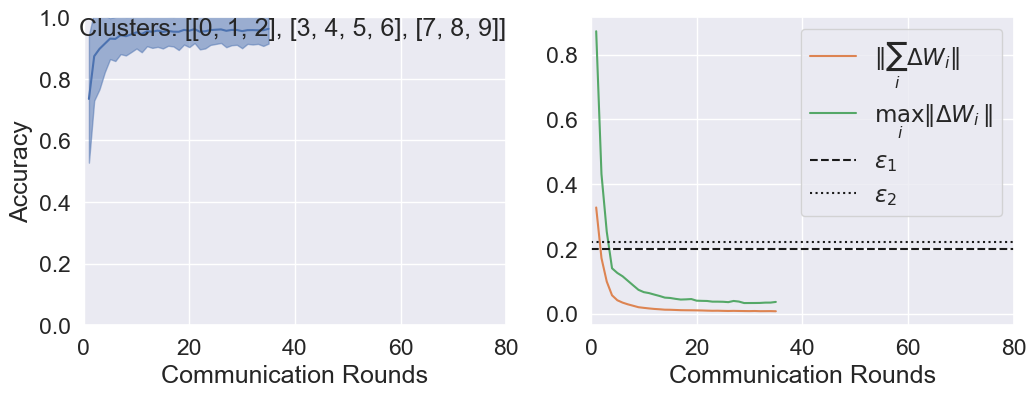

2025/02/02 13:15:08, line: 39     INFO | training done for client no 4 with loss of 0.25781332238300425
2025/02/02 13:15:10, line: 39     INFO | training done for client no 3 with loss of 0.10329856009307317
2025/02/02 13:15:11, line: 39     INFO | training done for client no 7 with loss of 0.01777996605044694
2025/02/02 13:15:11, line: 39     INFO | training done for client no 5 with loss of 0.1313028969253113
2025/02/02 13:15:12, line: 39     INFO | training done for client no 2 with loss of 9.860416925221215e-06
2025/02/02 13:15:12, line: 39     INFO | training done for client no 6 with loss of 0.005602313672689957
2025/02/02 13:15:13, line: 39     INFO | training done for client no 1 with loss of 0.08753282616300127
2025/02/02 13:15:14, line: 39     INFO | training done for client no 9 with loss of 0.09234476372021459


KeyboardInterrupt: 

In [33]:
# EPS_1 = 0.2
# EPS_2 = 0.22

# cfl_stats = ExperimentLogger()

# cluster_indices = [np.arange(len(clients)).astype("int")]
# client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

# for c_round in range(1, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"] + 1):


#     if c_round == 1:

#         for client in clients:

#             client.synchronize_with_server(server)


#     participating_clients = server.select_clients(clients, frac=1.0)

#     log.info(
#         f"number of participating clients is: {len(participating_clients)} at round number: {c_round}"
#     )


#     for client in participating_clients:

#         train_stats = client.compute_weight_update(
#             epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"]
#         )
#         client.reset()


#     similarities = server.compute_pairwise_similarities(clients)

#     #! clustering
    
#     cluster_indices_new = []
#     for idc in cluster_indices:
#         max_norm = server.compute_max_update_norm([clients[i] for i in idc])
#         mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        
#         if mean_norm < EPS_1 and max_norm > EPS_2 and len(idc) > 2 and c_round > 5:
#             log.info("Clustering triggered")
#             server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
#             similarities_sub = similarities[idc][:, idc]
#             c1, c2 = server.cluster_clients(similarities_sub)

#             c1_global = [idc[i] for i in c1]
#             c2_global = [idc[i] for i in c2]
            
#             cluster_indices_new += [c1_global, c2_global]

#             cfl_stats.log({"split": c_round})
#         else:
#             cluster_indices_new += [idc]
    
#     cluster_indices = cluster_indices_new
#     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

#     server.aggregate_clusterwise(client_clusters)

#     acc_clients = [client.evaluate() for client in clients]

#     cfl_stats.log(
#         {
#             "acc_clients": acc_clients,
#             "mean_norm": mean_norm,
#             "max_norm": max_norm,
#             "rounds": c_round,
#             "clusters": cluster_indices,
#         }
#     )

#     display_train_stats(
#         cfl_stats, EPS_1, EPS_2, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"]
#     )


# for idc in cluster_indices:
#     server.cache_model(idc, clients[idc[0]].W, acc_clients)

EPS_1 = 0.2
EPS_2 = 0.22

cfl_stats = ExperimentLogger()
cluster_indices = [np.arange(len(clients)).astype("int")]

for c_round in range(1, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"] + 1):
    # Synchronize and train clients
    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
    
    participating_clients = server.select_clients(clients, frac=1.0)
    for client in participating_clients:
        client.compute_weight_update(epochs=SAFE_PFL_CONFIG["ROUND_EPOCHS"])
        #! client.reset()
    
    # Compute full similarity matrix
    full_similarities = server.compute_pairwise_similarities(clients)

    global_mean_norm = server.compute_mean_update_norm(clients)
    global_max_norm = server.compute_max_update_norm(clients)

    # if global_mean_norm < EPS_1 and global_max_norm > EPS_2 and c_round > 5:
    if c_round % 6 == 0:
        log.warn("!!!!Global clustering triggered!!!!")
        log.info("similarity matrix")
        log.info(full_similarities)
        
        clustering = server.cluster_clients(full_similarities)
        
        # Update clusters
        cluster_indices = []
        for label in np.unique(clustering.labels_):
            cluster_indices.append(np.where(clustering.labels_ == label)[0].tolist())
    
    # Aggregate and log
    client_clusters = [[clients[i] for i in idc] for idc in cluster_indices]
    server.aggregate_clusterwise(client_clusters)    
    
    acc_clients = [client.evaluate() for client in clients]
    cfl_stats.log({
        "acc_clients": acc_clients,
        "mean_norm": global_mean_norm,
        "max_norm": global_max_norm,
        "rounds": c_round,
        "clusters": cluster_indices,
    })

    display_train_stats(cfl_stats, EPS_1, EPS_2, SAFE_PFL_CONFIG["FEDERATED_LEARNING_ROUNDS"])

# Final caching
for idc in cluster_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [34]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [42]:
import pandas as pd

frame = pd.DataFrame(results, columns=["Model {}".format(i) 
                                                    for i in range(results.shape[1])],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
Model 0,0.945255,0.946429,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 1,0.000000,0.000000,0.000000,0.946970,0.839744,0.945312,0.000000,0.000000,0.000000,0.000000
Model 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994253,1.000000,0.995283,0.962025
